In [2]:
import warnings
warnings.filterwarnings('ignore')
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

from collections import Counter
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
from helper_functions import *
import glob
import numpy as np
%matplotlib inline

In [10]:
country_langs = {"ARG": "es", "AUS": "en", "BEL": "fr", "BRA": "pt", "COL": "es", "CRC": "es"
, "DEN": "da", "EGY": "ar", "ENG": "en", "FRA": "fr", "GER": "de", "ISL": "is", "IRN": "fa"
, "JPN": "ja", "KOR": "ko", "MEX": "es", "MAR": "ar", "NGA": "en","PAN": "es", "PER": "es"
, "POL": "pl", "POR": "pt", "RUS": "ru", "KSA": "ar", "SEN": "fr", "SRB": "sr", "ESP": "es"
, "SWE": "sv", "SUI": "de_fr_it", "TUN": "ar", "URU": "es", "CRO": "hr"}

In [17]:
dir_path = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/"

In [23]:
trigger_mode = "mono"
num_neigh = 3
min_clus = 10
n_time_windows = 1 
time_window_size = 2
sub_window_size = 1 

In [24]:
bs = BurstySegmentation()
ed = EventDetector()

## Outline:
<a href='#qualitative_analysis'>I. Qualitative Analysis</a>

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <a href='#quali_ana_method'> a) Method</a>

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <a href='#quali_ana_res'> b) Results</a>

<a href='#quanti_ana_no_g_t'>II. Quantitative Analysis without Ground Truth</a>

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <a href='#quant_ana_no_g_t_method'> a) Method</a>

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <a href='#quant_ana_no_g_t_res'> b) Results</a>

<a href='#quant_ana_g_t'> III. Quantitative Analysis with Ground Truth</a>

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <a href='#quant_ana_g_t_method'> a) Method</a>

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <a href='#quant_ana_g_t_res'> b) Results</a>

<a href='#keyword_freq'> IV. Analysis based on keyword frequency</a>

<a href='#example'> V. Examples</a>

# I. Qualitative Analysis: 
For each game, analyze the number of clusters, avg/max/min number of triggers per cluster
<a id='qualitative_analysis'></a>

<a id='quali_ana_method'></a> 

In [146]:
home_teams = []
away_teams = []
date_matches = []
times_matches = []
matches_names = []
fixture = pd.read_csv("/Users/meryemmhamdi/Downloads/world_cup18_fixture.csv")
fixture = fixture[fixture["Round"] == "Group Round (1st)"].reset_index()
for i in range(len(fixture)):
    if fixture.iloc[i]["to_analyze"] == 1:
        home_teams.append(fixture.iloc[i]["home_team/code"])
        away_teams.append(fixture.iloc[i]["away_team/code"])
        date_matches.append(fixture.iloc[i]["date_time"])
        times_matches.append(fixture.iloc[i]["Time"])
        day = fixture.iloc[i]["date_time"].split("_")[0]
        month = fixture.iloc[i]["date_time"].split("_")[1]
        year = fixture.iloc[i]["date_time"].split("_")[2]
        hour = fixture.iloc[i]["Time"].split(":")[0]
        if day[0] == "0":
            day = day[1]
        if month[0] == "0":
            month = month[1]
        if hour[0] == "0":
            hour = hour[1]
        langs = set()
        langs.add("en")

        home_langs = country_langs[fixture.iloc[i]["home_team/code"]]
        away_langs = country_langs[fixture.iloc[i]["away_team/code"]]
        if "_" in home_langs:
            for lang in home_langs.split("_"):
                langs.add(lang)
        else:
            langs.add(home_langs)

        if "_" in away_langs:
            for lang in away_langs.split("_"):
                langs.add(lang)
        else:
            langs.add(away_langs)
        
        teams = fixture.iloc[i]["home_team/code"]+"-"+fixture.iloc[i]["away_team/code"]
        date = day+"_"+month+"_"+year+"-"+hour
        matches_names.append(teams+"-"+date+"-"+"_".join(list(langs)))
        
quali_ana = {}
for sub_dir in [dir_path + "GER-MEX-17_6_2018-15-de_en_es"]:#glob.glob(dir_path+"*"):
    match_metadata = sub_dir.split("/")[-1]
    print(match_metadata)
    if match_metadata != "archives" and match_metadata != "COL-ENG-3_7_2018-18-en_es" and match_metadata != "FRA-ARG-30_6_2018-14-fr_en_es" and match_metadata != "BRA-MEX-2_7_2018-14-en_es_pt" and match_metadata != "SUI-CRC-27_6_2018-18-de_en_fr_es_it":   
        langs = match_metadata.split("-")[4]

        year = int(match_metadata.split("-")[2].split("_")[2])
        month = int(match_metadata.split("-")[2].split("_")[1])
        day = int(match_metadata.split("-")[2].split("_")[0])
        hour = int(match_metadata.split("-")[3])
        
        start = datetime.datetime(year, month, day, hour, 0, 0) 
        sws_time = get_sws_times(langs.split("_"), start)
        
        clusters_info = {}
        print("Multilingual clusters")
        # Multilingual clusters
        with open(dir_path+ match_metadata+"/emb_multi_"+langs+"_"+trigger_mode+"-trigger_"+str(num_neigh)
                  +"-neigh_"+str(min_clus)+"-min-cluster-seg.txt") as multi_file:
            clusters = multi_file.readlines()[5:]

        triggers = []
        triggers_len = []
        for event in clusters:
            trigger = event.split(":")[1].split("\t")
            triggers.append(trigger)
            triggers_len.append(len(trigger))
            
        print("triggers:",triggers)
            
        counts_tweets = find_total_tweets(triggers, sws_time)

        if len(triggers_len) > 0:
            info = {"#clus": len(clusters), "#tweets":counts_tweets, "#trig(max)":max(triggers_len), "#trig(min)":min(triggers_len), "#trig(avg)":np.mean(triggers_len) }
        else:
            info = {"#clus": 0, "#tweets":counts_tweets, "#trig(max)":0, "#trig(min)":0, "#trig(avg)":0 }

        home_team = match_metadata.split("-")[0]
        away_team = match_metadata.split("-")[1]
        clusters_info.update({"multi_en_"+country_langs[home_team]+"_"+country_langs[away_team]:info})
        print("Monolingual Clusters")
        # Monolingual Clusters
        for lang in langs.split("_"):
            with open(dir_path+ match_metadata+"/emb_mono_"+lang+"_"+trigger_mode+"-trigger_"+str(num_neigh)+"-neigh_"+str(min_clus)
                      +"-min-cluster-seg.txt") as multi_file:
                clusters = multi_file.readlines()[5:]

            triggers = []
            triggers_len = []
            for event in clusters:
                trigger = event.split(":")[1].split("\t")
                triggers.append(trigger)
                triggers_len.append(len(trigger))
            
            counts_tweets = find_total_tweets(triggers, sws_time)

            if len(triggers_len) > 0:
                info = {"#clus": len(clusters), "#tweets":counts_tweets, "#trig(max)":max(triggers_len), "#trig(min)":min(triggers_len), "#trig(avg)":np.mean(triggers_len) }
            else:
                info = {"#clus": 0, "#tweets":counts_tweets, "#trig(max)":0, "#trig(min)":0, "#trig(avg)":0}
            clusters_info.update({"mono_"+lang:info})

            quali_ana.update({match_metadata: clusters_info})

 22%|██▏       | 109/505 [00:00<00:00, 1083.72it/s]

GER-MEX-17_6_2018-15-de_en_es
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: de
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  5%|▍         | 78/1701 [00:00<00:02, 775.64it/s]

Number of Tweets Found:  505
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


  0%|          | 0/22166 [00:00<?, ?it/s]

Number of Tweets Found:  1701
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 0/26190 [00:00<?, ?it/s]

Number of Tweets Found:  22166
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


  1%|          | 74/13832 [00:00<00:18, 734.36it/s]

Number of Tweets Found:  26190
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 0/23237 [00:00<?, ?it/s]

Number of Tweets Found:  13832
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


100%|██████████| 23237/23237 [00:21<00:00, 1058.91it/s]


Number of Tweets Found:  23237
Aggregating the Time Windows=>
Multilingual clusters
triggers: [['es_carlos', 'de_mex', 'de_mundial', 'de_vela', 'es_javier', 'de_herrera', 'de_moreno', 'en_ochoa', 'es_mex', 'de_hernandez', 'es_juan', 'en_carlos', 'es_hernández', 'en_lozano\n'], ['en_coffee', 'es_dormir', 'es_cerveza', 'es_desayunar', 'en_sleep', 'en_drink', 'en_beer', 'en_eat', 'es_caminar', 'en_tea', 'de_germany', 'es_nadar', 'es_andar', 'es_budweiser', 'es_comer', 'en_food\n'], ['en_champions', 'en_championship', 'es_cup', 'en_cup', 'en_tournament', 'es_ganador', 'en_title', 'es_título', 'en_champion', 'en_winner', 'es_football', 'es_campeón', 'de_football', 'es_copa\n'], ['en_root', 'de_daumen', 'es_cabeza', 'en_head', 'de_drücken', 'es_falto', 'es_nervio', 'en_heart', 'es_corazón', 'es_nervioso', 'en_hand', 'es_piel', 'en_eye', 'es_ojo', 'en_foot\n'], ['es_pensar', 'es_olvidar', 'en_forget', 'es_entender', 'es_darle', 'en_remember', 'en_know', 'en_appreciate', 'en_ask', 'es_gracias'

In [147]:
modes = set()
for match in quali_ana:
    for mode in quali_ana[match]:
        if "multi" in mode:
            modes.add("multi")
        else:
            modes.add(mode)
modes = list(modes)
modes

['mono_de', 'mono_en', 'multi', 'mono_es']

<a id='quali_ana_res'></a> 

In [149]:
dictionary_qualit = {}
for mode in modes:
    for match in quali_ana:
        if mode not in dictionary_qualit:
            dictionary_qualit.update({mode:{"#clus": ['-'], "#tweets":['-'] , "#trig(max)": ['-'], "#trig(min)": ['-'], "#trig(avg)": ['-']}})
        else:
            dictionary_qualit[mode]["#clus"].append("-")
            dictionary_qualit[mode]["#tweets"].append("-")
            dictionary_qualit[mode]["#trig(max)"].append("-")
            dictionary_qualit[mode]["#trig(min)"].append("-")
            dictionary_qualit[mode]["#trig(avg)"].append("-")
            dictionary_qualit.update({mode:{"#clus":dictionary_qualit[mode]["#clus"], "#tweets":dictionary_qualit[mode]["#tweets"], "#trig(max)": dictionary_qualit[mode]["#trig(max)"],
                                      "#trig(min)":dictionary_qualit[mode]["#trig(min)"], "#trig(avg)": dictionary_qualit[mode]["#trig(avg)"]}})
            
i = 0
for match in quali_ana:
    for mode in quali_ana[match]:
        num_clus =  round(quali_ana[match][mode]["#clus"],2)
        num_tweets =  round(quali_ana[match][mode]["#tweets"],2)
        max_trig =  round(quali_ana[match][mode]["#trig(max)"],2)
        min_trig =  round(quali_ana[match][mode]["#trig(min)"],2)
        avg_trig =  round(quali_ana[match][mode]["#trig(avg)"],2)
        if "multi" in mode:
            mode = "multi"
        
        dictionary_qualit[mode]["#clus"][i] = num_clus
        dictionary_qualit[mode]["#tweets"][i] = num_tweets
        dictionary_qualit[mode]["#trig(max)"][i] = max_trig
        dictionary_qualit[mode]["#trig(min)"][i] = min_trig
        dictionary_qualit[mode]["#trig(avg)"][i] = avg_trig
        dictionary_qualit.update({mode: {"#clus":dictionary_qualit[mode]["#clus"], "#tweets":dictionary_qualit[mode]["#tweets"], "#trig(max)":dictionary_qualit[mode]["#trig(max)"],
                                  "#trig(min)":dictionary_qualit[mode]["#trig(min)"], "#trig(avg)":dictionary_qualit[mode]["#trig(avg)"]}})
    i += 1
    
dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary_qualit.items() for innerKey, values in innerDict.items()}
df = pd.DataFrame(dict_index)
df.insert(loc=0, column='Games', value=list(quali_ana.keys()))
df.reset_index(drop = True, inplace = True)
#df.to_csv("/Users/meryemmhamdi/Desktop/qualitative_analysis.csv", index = False)
df

Games mono_de                                          mono_en                                          mono_es                                          multi                                         
                                   #clus #trig(avg) #trig(max) #trig(min) #tweets   #clus #trig(avg) #trig(max) #trig(min) #tweets   #clus #trig(avg) #trig(max) #trig(min) #tweets #clus #trig(avg) #trig(max) #trig(min) #tweets
0  GER-MEX-17_6_2018-15-de_en_es       2       16.0         17         15    1423       6      21.83         35         10   38628      11      14.64         26         10   22154    19      20.95         68         10   69835

In [174]:
df = pd.read_csv("/Users/meryemmhamdi/Desktop/Thesis/eventResultsCSV/qualitative_analysis.csv")


,Games,mono_ar,mono_ar.1,mono_ar.2,mono_ar.3,mono_ar.4,mono_da,mono_da.1,mono_da.2,mono_da.3,mono_da.4,mono_de,mono_de.1,mono_de.2,mono_de.3,mono_de.4,mono_en,mono_en.1,mono_en.2,mono_en.3,mono_en.4,mono_es,mono_es.1,mono_es.2,mono_es.3,mono_es.4,mono_fa,mono_fa.1,mono_fa.2,mono_fa.3,mono_fa.4,mono_fr,mono_fr.1,mono_fr.2,mono_fr.3,mono_fr.4,mono_is,mono_is.1,mono_is.2,mono_is.3,mono_is.4,mono_it,mono_it.1,mono_it.2,mono_it.3,mono_it.4,mono_ja,mono_ja.1,mono_ja.2,mono_ja.3,mono_ja.4,mono_ko,mono_ko.1,mono_ko.2,mono_ko.3,mono_ko.4,mono_pl,mono_pl.1,mono_pl.2,mono_pl.3,mono_pl.4,mono_pt,mono_pt.1,mono_pt.2,mono_pt.3,mono_pt.4,mono_ru,mono_ru.1,mono_ru.2,mono_ru.3,mono_ru.4,mono_sr,mono_sr.1,mono_sr.2,mono_sr.3,mono_sr.4,multi,multi.1,multi.2,multi.3,multi.4
0,NaN,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets,#clus,#trig(avg),#trig(max),#trig(min),#tweets
1,PAN-TUN-28_6_2018-18-en_ar_es,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,5,15.6,21,12,8979,6,21.5,57,10,14319,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,18,19.33,101,10,31887
2,SRB-BRA-27_6_2018-18-sr_en_pt,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,5,13.8,16,11,10955,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1,12.0,12,12,436,-,-,-,-,-,0,0,0,0,0,8,14.5,21,10,11919
3,URU-KSA-20_6_2018-15-en_ar_es,3,11.33,14,10,531,-,-,-,-,-,-,-,-,-,-,8,12.0,15,10,9791,6,25.83,57,11,18569,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,12,26.67,125,10,31529
4,COL-JPN-19_6_2018-12-en_ja_es,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,8,16.5,27,11,21967,6,20.0,47,10,12163,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,17,17.35,38,10,28953


In [175]:
df.columns

Index(['Games', 'mono_ar', 'mono_ar.1', 'mono_ar.2', 'mono_ar.3', 'mono_ar.4', 'mono_da', 'mono_da.1', 'mono_da.2', 'mono_da.3', 'mono_da.4', 'mono_de', 'mono_de.1', 'mono_de.2', 'mono_de.3', 'mono_de.4', 'mono_en', 'mono_en.1', 'mono_en.2', 'mono_en.3', 'mono_en.4', 'mono_es', 'mono_es.1', 'mono_es.2', 'mono_es.3', 'mono_es.4', 'mono_fa', 'mono_fa.1', 'mono_fa.2', 'mono_fa.3', 'mono_fa.4', 'mono_fr', 'mono_fr.1', 'mono_fr.2', 'mono_fr.3', 'mono_fr.4', 'mono_is', 'mono_is.1', 'mono_is.2', 'mono_is.3', 'mono_is.4', 'mono_it', 'mono_it.1', 'mono_it.2', 'mono_it.3', 'mono_it.4', 'mono_ja', 'mono_ja.1', 'mono_ja.2', 'mono_ja.3', 'mono_ja.4', 'mono_ko', 'mono_ko.1', 'mono_ko.2', 'mono_ko.3', 'mono_ko.4', 'mono_pl', 'mono_pl.1', 'mono_pl.2', 'mono_pl.3', 'mono_pl.4', 'mono_pt', 'mono_pt.1', 'mono_pt.2', 'mono_pt.3', 'mono_pt.4', 'mono_ru', 'mono_ru.1', 'mono_ru.2', 'mono_ru.3', 'mono_ru.4', 'mono_sr', 'mono_sr.1', 'mono_sr.2', 'mono_sr.3', 'mono_sr.4', 'multi', 'multi.1', 'multi.2',
       '

In [210]:
clus_list = []
trig_avg_list = []
trig_max_list = []
trig_min_list = []
tweets_list = []
modes_ch = []

for mode in sorted(modes):
    if mode not in ["mono_da", "mono_is", "mono_ja", "mono_sr"]:
        if "mono" in mode:
            modes_ch.append(mode.split("_")[1])
        else:
            modes_ch.append(mode)
        clus = 0
        num_clus = 0
        for el in list(df[mode]):#["#clus"]):
            if el != "-" and el !="#clus":
                clus += float(el)
                num_clus += 1

        clus_list.append(round(clus/num_clus,2))

        clus = 0
        num_clus = 0
        for el in list(df[mode+".1"]):#["#trig(avg)"]):
            if el != "-" and el !="#trig(avg)":
                clus += float(el)
                num_clus += 1

        trig_avg_list.append(round(clus/num_clus,2))

        clus = []
        for el in list(df[mode+".2"]):#["#trig(max)"]):
            if el != "-" and el != "#trig(max)":
                clus.append(float(el))

        trig_max_list.append(max(clus))

        clus = []
        print(mode+".3")
        for el in list(df[mode+".3"]):#["#trig(min)"]):
            if el != "-" and el != "#trig(min)" and float(el) > 0:
                clus.append(float(el))

        trig_min_list.append(min(clus))

        clus = 0
        num_clus = 0
        for el in list(df[mode+".4"]):#["#tweets"]):
            if el != "-" and el != "#tweets":
                clus += float(el)
                num_clus += 1

        tweets_list.append(int(clus/num_clus))

mono_ar.3
mono_de.3
mono_en.3
mono_es.3
mono_fa.3
mono_fr.3
mono_it.3
mono_ko.3
mono_pl.3
mono_pt.3
mono_ru.3
multi.3


In [205]:
print(clus_list)
print(trig_avg_list)
print(trig_max_list)
print(trig_min_list)
print(tweets_list)

[2.0, 0.0, 2.25, 5.91, 6.26, 0.33, 2.58, 0.0, 2.0, 0.0, 0.5, 0.67, 3.14, 0.5, 0.0, 12.8]
[11.58, 0.0, 14.58, 15.85, 20.15, 7.0, 13.74, 0.0, 12.66, 0.0, 6.0, 9.67, 14.15, 7.0, 0.0, 19.92]
[21.0, 0.0, 18.0, 47.0, 79.0, 21.0, 22.0, 0.0, 15.0, 0.0, 12.0, 16.0, 26.0, 16.0, 0.0, 208.0]
[0.0, 0.0, 11.0, 10.0, 0.0, 0.0, 10.0, 0.0, 11.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 10.0]
[805, 0, 1824, 22176, 17217, 134, 1330, 0, 1160, 0, 20, 344, 6324, 72, 0, 32620]


In [211]:
df_avg = pd.DataFrame(index=modes_ch)
df_avg["#Clusters"] = clus_list
df_avg["Min Triggers"] = trig_min_list
df_avg["Avg Triggers"] = trig_avg_list
df_avg["Max Triggers"] = trig_max_list
df_avg["# Tweets"] = tweets_list
df_avg.index.name = "Languages Mode"
#df_avg.insert(loc=0, column='Modes', value=modes)
#df_avg.reset_index(drop = True, inplace = True)
#df_avg.to_csv("/Users/meryemmhamdi/Desktop/Thesis/eventResultsCSV/qualitative_analysis_average_new.csv")
df_avg

,#Clusters,Min Triggers,Avg Triggers,Max Triggers,# Tweets
Languages Mode,,,,,
ar,2.00,10.0,11.58,21.0,805
de,2.25,11.0,14.58,18.0,1824
en,5.91,10.0,15.85,47.0,22176
es,6.26,10.0,20.15,79.0,17217
fa,0.33,21.0,7.00,21.0,134
fr,2.58,10.0,13.74,22.0,1330
it,2.00,11.0,12.66,15.0,1160
ko,0.50,12.0,6.00,12.0,20
pl,0.67,13.0,9.67,16.0,344


In [192]:
df_avg.to_csv("/Users/meryemmhamdi/Desktop/Thesis/eventResultsCSV/qualitative_analysis_average.csv")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-192-737358ea8344>", line 1, in <module>
    df_avg.to_csv("/Users/meryemmhamdi/Desktop/Thesis/eventResultsCSV/qualitative_analysis_average.csv")
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py", line 1524, in to_csv
    formatter.save()
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/pandas/io/formats/format.py", line 1637, in save
    compression=self.compression)
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/pandas/io/common.py", line 318, in _get_handle
    from s3fs import S3File
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 951, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 894, in 

OSError: [Errno 5] Input/output error: '..'

In [53]:
df_avgT = df_avg.T
df_avgT.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/qualitative_analysis_average_transpose.csv")

In [764]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
s = pd.DataFrame(np.random.randn(8), index=index)
s

0
first second          
bar   one    -1.835594
      two     1.422430
baz   one     0.236836
      two    -0.893951
foo   one    -1.671934
      two    -1.016720
qux   one    -1.539714
      two    -0.187784

In [743]:
df2 = df.unstack(level=[0])
df2.to_frame().reset_index()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454
level_0,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_de,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_en,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_es,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_fr,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,mono_it,m

In [706]:
df2 = pd.melt(df, id_vars=["Games"], var_name="Date", value_name="Value")
df2

,Games,Date,Value
0,BEL-PAN-18_6_2018-15-fr_en_es,mono_de,-
1,FRA-PER-21_6_2018-15-fr_en_es,mono_de,-
2,FRA-AUS-16_6_2018-10-fr_en,mono_de,-
3,ENG-PAN-24_6_2018-12-en_es,mono_de,-
4,SEN-COL-28_6_2018-14-fr_en_es,mono_de,-
5,NGA-ARG-26_6_2018-18-en_es,mono_de,-
6,URU-POR-30_6_2018-18-en_pt_es,mono_de,-
7,POR-ESP-15_6_2018-18-en_es_pt,mono_de,-
8,AUS-PER-26_6_2018-14-en_es,mono_de,-
9,GER-MEX-17_6_2018-15-de_en_es,mono_de,2


In [686]:
quali_ana
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame.from_dict(quali_ana) #pd.DataFrame(quant_ana)
#for col in df.columns:
#df["AUS-PER-26_6_2018-14-en_es"] = df["AUS-PER-26_6_2018-14-en_es"].apply(pd.Series)
df
#df.head()

,AUS-PER-26_6_2018-14-en_es,BEL-PAN-18_6_2018-15-fr_en_es,BRA-CRC-22_6_2018-12-en_es_pt,BRA-SUI-17_6_2018-18-de_en_fr_pt_it,ENG-BEL-28_6_2018-18-fr_en,ENG-PAN-24_6_2018-12-en_es,FRA-AUS-16_6_2018-10-fr_en,FRA-PER-21_6_2018-15-fr_en_es,GER-MEX-17_6_2018-15-de_en_es,NGA-ARG-26_6_2018-18-en_es,POR-ESP-15_6_2018-18-en_es_pt,SEN-COL-28_6_2018-14-fr_en_es,URU-POR-30_6_2018-18-en_pt_es
mono_de,NaN,NaN,NaN,"{'#clus': 2, '#tweets': 2920, '#trig(max)': 16, '#trig(min)': 16, '#trig(avg)': 14.5}",NaN,NaN,NaN,NaN,"{'#clus': 2, '#tweets': 1423, '#trig(max)': 17, '#trig(min)': 17, '#trig(avg)': 16.0}",NaN,NaN,NaN,NaN
mono_en,"{'#clus': 1, '#tweets': 6618, '#trig(max)': 20, '#trig(min)': 20, '#trig(avg)': 20.0}","{'#clus': 7, '#tweets': 38630, '#trig(max)': 45, '#trig(min)': 45, '#trig(avg)': 22.571428571428573}","{'#clus': 2, '#tweets': 7923, '#trig(max)': 18, '#trig(min)': 18, '#trig(avg)': 17.0}","{'#clus': 14, '#tweets': 111433, '#trig(max)': 47, '#trig(min)': 47, '#trig(avg)': 19.071428571428573}","{'#clus': 5, '#tweets': 0, '#trig(max)': 21, '#trig(min)': 21, '#trig(avg)': 15.6}","{'#clus': 4, '#tweets': 12849, '#trig(max)': 13, '#trig(min)': 13, '#trig(avg)': 11.25}","{'#clus': 8, '#tweets': 25934, '#trig(max)': 35, '#trig(min)': 35, '#trig(avg)': 16.75}","{'#clus': 5, '#tweets': 7958, '#trig(max)': 14, '#trig(min)': 14, '#trig(avg)': 12.2}","{'#clus': 6, '#tweets': 38628, '#trig(max)': 35, '#trig(min)': 35, '#trig(avg)': 21.833333333333332}","{'#clus': 3, '#tweets': 9660, '#trig(max)': 21, '#trig(min)': 21, '#trig(avg)': 15.666666666666666}","{'#clus': 12, '#tweets': 54759, '#trig(max)': 31, '#trig(min)': 31, '#trig(avg)': 15.25}","{'#clus': 6, '#tweets': 0, '#trig(max)': 17, '#trig(min)': 17, '#trig(avg)': 12.666666666666666}","{'#clus': 4, '#tweets': 0, '#trig(max)': 26, '#trig(min)': 26, '#trig(avg)': 16.75}"
mono_es,"{'#clus': 6, '#tweets': 14693, '#trig(max)': 36, '#trig(min)': 36, '#trig(avg)': 22.166666666666668}","{'#clus': 8, '#tweets': 20811, '#trig(max)': 30, '#trig(min)': 30, '#trig(avg)': 17.625}","{'#clus': 6, '#tweets': 0, '#trig(max)': 43, '#trig(min)': 43, '#trig(avg)': 22.166666666666668}",NaN,NaN,"{'#clus': 5, '#tweets': 13407, '#trig(max)': 50, '#trig(min)': 50, '#trig(avg)': 23.6}",NaN,"{'#clus': 7, '#tweets': 14849, '#trig(max)': 33, '#trig(min)': 33, '#trig(avg)': 19.428571428571427}","{'#clus': 11, '#tweets': 22154, '#trig(max)': 26, '#trig(min)': 26, '#trig(avg)': 14.636363636363637}","{'#clus': 4, '#tweets': 9280, '#trig(max)': 49, '#trig(min)': 49, '#trig(avg)': 21.25}","{'#clus': 6, '#tweets': 22146, '#trig(max)': 53, '#trig(min)': 53, '#trig(avg)': 24.5}","{'#clus': 6, '#tweets': 0, '#trig(max)': 53, '#trig(min)': 53, '#trig(avg)': 22.666666666666668}","{'#clus': 5, '#tweets': 0, '#trig(max)': 37, '#trig(min)': 37, '#trig(avg)': 21.4}"
mono_fr,NaN,"{'#clus': 2, '#tweets': 758, '#trig(max)': 14, '#trig(min)': 14, '#trig(avg)': 12.0}",NaN,"{'#clus': 2, '#tweets': 1144, '#trig(max)': 21, '#trig(min)': 21, '#trig(avg)': 15.5}","{'#clus': 3, '#tweets': 0, '#trig(max)': 12, '#trig(min)': 12, '#trig(avg)': 10.666666666666666}",NaN,"{'#clus': 3, '#tweets': 995, '#trig(max)': 15, '#trig(min)': 15, '#trig(avg)': 12.0}","{'#clus': 3, '#tweets': 1507, '#trig(max)': 13, '#trig(min)': 13, '#trig(avg)': 11.333333333333334}",NaN,NaN,NaN,"{'#clus': 4, '#tweets': 0, '#trig(max)': 16, '#trig(min)': 16, '#trig(avg)': 12.5}",NaN
mono_it,NaN,NaN,NaN,"{'#clus': 3, '#tweets': 1249, '#trig(max)': 15, '#trig(min)': 15, '#trig(avg)': 12.333333333333334}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mono_pt,NaN,NaN,"{'#clus': 3, '#tweets': 3643, '#trig(max)': 19, '#trig(min)': 19, '#trig(avg)': 14.666666666666666}","{'#clus': 6, '#tweets': 26205, '#trig(max)': 26, '#trig(min)': 26, '#trig(avg)': 18.5}",NaN,NaN,NaN,NaN,NaN,NaN,"{'#clus': 3, '#tweets': 7034, '#trig(max)': 22, '#trig(min)': 22, '#trig(avg)': 18.0}",NaN,"{'#clus': 2, '#tweets': 383, '#trig(max)': 14, '#trig(min)': 14, '#trig(avg)': 13.0}"
multi_en_de_es,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [108]:
### Loading csv results file: 
df_qual_stored = pd.read_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/qualitative_analysis_average.csv")
#df_qual_stored
df_qual_stored = df_qual_stored[~df_qual_stored["Languages Mode"].isin(["da", "is", "ja", "sr"])]
df_qual_stored.set_index("Languages Mode")
df_qual_stored.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/qualitative_analysis_avg_red_lang.csv")

# II. Quantitative Analysis without Ground Truth:
Analyze the number of peaks above sigma (wavelent analysis)
<a id='quanti_ana_no_g_t'></a>

<a id='quant_ana_no_g_t_method'></a>

In [18]:
quant_ana = {}
for sub_dir in glob.glob(dir_path+"*"):
    match_metadata = sub_dir.split("/")[-1]
    print (match_metadata)
    #if match_metadata == "FRA-PER-21_6_2018-15-fr_en_es" or match_metadata == "URU-POR-30_6_2018-18-en_pt_es":
    if match_metadata != "archives" and match_metadata in ["GER-MEX-17_6_2018-15-de_en_es", "POR-ESP-15_6_2018-18-en_es_pt"]: # match_metadata != "COL-ENG-3_7_2018-18-en_es" and match_metadata != "FRA-ARG-30_6_2018-14-fr_en_es" and match_metadata != "BRA-MEX-2_7_2018-14-en_es_pt" and match_metadata != "SUI-CRC-27_6_2018-18-de_en_fr_es_it":   
        print("PROCESSING MATCH: ", match_metadata)
        print("-------------------------------------------------")
        langs = match_metadata.split("-")[4]
        
        print("1. Read Time windows relative to the game")
        year = int(match_metadata.split("-")[2].split("_")[2])
        month = int(match_metadata.split("-")[2].split("_")[1])
        day = int(match_metadata.split("-")[2].split("_")[0])
        hour = int(match_metadata.split("-")[3])
        
        start = datetime.datetime(year, month, day, hour, 0, 0) 
        sws_time = get_sws_times(langs.split("_"), start)
        
        print("2. Read Event Clusters and their triggers for multilingual and monolingual experiments")
        clusters_info = {}
        print("Multilingual clusters")
        # Multilingual clusters
        with open(dir_path+ match_metadata+"/emb_multi_"+langs+"_"+trigger_mode+"-trigger_"+str(num_neigh)
                  +"-neigh_"+str(min_clus)+"-min-cluster-seg.txt") as multi_file:
            clusters = multi_file.readlines()[5:]

        triggers = []
        for event in clusters:
            trigger = event.split(":")[1].split("\t")
            triggers.append(trigger)
            
        print("3. Find counts for the multilingual experiment")
        counts = find_counts(triggers, sws_time)
        
        print("4. Measure quantitative metrics for the monolingual event clusters")
        counts_events_1_std, counts_events_2_std, counts_events_3_std, ev_1_trig, ev_2_trig, ev_3_trig = quant_metrics(counts, start, triggers)
        info = {"1_std": [len(counts_events_1_std),counts_events_1_std], "2_std":[len(counts_events_2_std),
              counts_events_2_std], "3_std":[len(counts_events_3_std), counts_events_3_std], "1std_trig":ev_1_trig, "2std_trig":ev_2_trig, "3std_trig":ev_3_trig }
        
        #print(info)
        home_team = match_metadata.split("-")[0]
        away_team = match_metadata.split("-")[1]
        clusters_info.update({"multi_en_"+country_langs[home_team]+"_"+country_langs[away_team]:info})
        
        print("Monolingual Clusters")
        # Monolingual Clusters
        for lang in langs.split("_"):
            with open(dir_path+ match_metadata+"/emb_mono_"+lang+"_"+trigger_mode+"-trigger_"+str(num_neigh)+"-neigh_"+str(min_clus)
                      +"-min-cluster-seg.txt") as multi_file:
                clusters = multi_file.readlines()[5:]

            triggers = []
            for event in clusters:
                trigger = event.split(":")[1].split("\t")
                triggers.append(trigger)
                
            sws_time = get_sws_times([lang], start)

            print("3. Find counts for monolingual experiments")
            counts = find_counts(triggers, sws_time)
            print("4. Measure quantitative metrics for the monolingual event clusters")
            counts_events_1_std, counts_events_2_std, counts_events_3_std, ev_1_trig, ev_2_trig, ev_3_trig = quant_metrics(counts, start, triggers)
            info = {"1_std": [len(counts_events_1_std),counts_events_1_std], "2_std":[len(counts_events_2_std),
                  counts_events_2_std], "3_std":[len(counts_events_3_std), counts_events_3_std] , "1std_trig":ev_1_trig, "2std_trig":ev_2_trig, "3std_trig":ev_3_trig }
            #print(info)
            clusters_info.update({"mono_"+lang:info})
            
        match = home_team + "-" + away_team + "-" + str(day) + "_" + str(month) + "_" + str(year) + "_" + str(hour) + "-" + country_langs[home_team]+"_"+country_langs[away_team]
        quant_ana.update({match: clusters_info})

  0%|          | 0/34593 [00:00<?, ?it/s]

PAN-TUN-28_6_2018-18-en_ar_es
SRB-BRA-27_6_2018-18-sr_en_pt
URU-KSA-20_6_2018-15-en_ar_es
COL-JPN-19_6_2018-12-en_ja_es
NGA-ISL-22_6_2018-15-is_en
SRB-SUI-22_6_2018-18-sr_de_en_fr_it
BEL-PAN-18_6_2018-15-fr_en_es
DEN-FRA-26_6_2018-14-fr_en_da
FRA-PER-21_6_2018-15-fr_en_es
FRA-AUS-16_6_2018-10-fr_en
KOR-MEX-23_6_2018-15-en_ko_es
ENG-PAN-24_6_2018-12-en_es
archives
IRN-POR-25_6_2018-18-fa_en_pt
ESP-MAR-25_6_2018-18-en_ar_es
SEN-COL-28_6_2018-14-fr_en_es
CRC-SRB-17_6_2018-12-sr_en_es
BEL-TUN-23_6_2018-12-fr_en_ar
NGA-ARG-26_6_2018-18-en_es
EGY-URU-15_6_2018-12-en_ar_es
URU-POR-30_6_2018-18-en_pt_es
POR-ESP-15_6_2018-18-en_es_pt
PROCESSING MATCH:  POR-ESP-15_6_2018-18-en_es_pt
-------------------------------------------------
1. Read Time windows relative to the game
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


100%|██████████| 34593/34593 [00:59<00:00, 583.01it/s]


Number of Tweets Found:  34593
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


  0%|          | 0/18145 [00:00<?, ?it/s]

Number of Tweets Found:  36927
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  0%|          | 0/22083 [00:00<?, ?it/s]

Number of Tweets Found:  18145
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


  1%|▏         | 53/3860 [00:00<00:07, 527.60it/s]

Number of Tweets Found:  22083
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: pt
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  1%|          | 53/4750 [00:00<00:08, 522.46it/s]

Number of Tweets Found:  3860
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


100%|██████████| 4750/4750 [00:06<00:00, 744.96it/s]


Number of Tweets Found:  4750
Aggregating the Time Windows=>
2. Read Event Clusters and their triggers for multilingual and monolingual experiments
Multilingual clusters


NameError: name 'trigger_mode' is not defined

In [19]:
def quant_metrics(counts, start, triggers): 
    count_events_1_std = set()
    count_events_2_std = set()
    count_events_3_std = set()
    
    count_events_1_trig = []
    count_events_2_trig = []
    count_events_3_trig = []
    
    list_counts = []
    for i in range(len(counts)):
        for el in list(counts[i].values()):
            list_counts.append(el)
            
    mean_y = np.mean(list_counts)
    std_y = np.std(list_counts)
    
    for i in range(len(counts)):
        mean_y = np.mean(list(counts[i].values()))
        std_y = np.std(list(counts[i].values()))
        x = list(counts[i].keys()) 
        y_c = list(counts[i].values())
        ## Ignoring Break time
        break_time_start = start + datetime.timedelta(minutes=48)
        break_time_end = break_time_start + datetime.timedelta(minutes=20)
        y_keep = []
        x_keep = []
        for j in range(len(y_c)):
            if x[j] < break_time_start or x[j] > break_time_end:
                x_keep.append(x[j])
                y_keep.append(y_c[j])
        #flag = False
        for j in range(0,len(y_keep)):
            if y_keep[j] >= (mean_y + 3* std_y): #and flag == False:
                count_events_3_std.add(x_keep[j])
                count_events_3_trig.append(triggers[i])
            if y_keep[j] >= (mean_y + 2* std_y):# and flag == False:
                count_events_2_std.add(x_keep[j])
                count_events_2_trig.append(triggers[i])
            if y_keep[j] >= (mean_y + std_y): #and flag== False:
                count_events_1_std.add(x_keep[j])
                count_events_1_trig.append(triggers[i])
                #flag = True
                
    return count_events_1_std, count_events_2_std, count_events_3_std, count_events_1_trig, count_events_2_trig, count_events_3_trig

In [25]:
quant_ana_1 = {}
for sub_dir in glob.glob(dir_path+"*"):
    match_metadata = sub_dir.split("/")[-1]
    print (match_metadata)
    #if match_metadata == "FRA-PER-21_6_2018-15-fr_en_es" or match_metadata == "URU-POR-30_6_2018-18-en_pt_es":
    if match_metadata in ["GER-MEX-17_6_2018-15-de_en_es", "POR-ESP-15_6_2018-18-en_es_pt"]:#not in ["archives", "COL-ENG-3_7_2018-18-en_es", "FRA-ARG-30_6_2018-14-fr_en_es", "BRA-MEX-2_7_2018-14-en_es_pt", "SUI-CRC-27_6_2018-18-de_en_fr_es_it"]:  #== "GER-MEX-17_6_2018-15-de_en_es": #or match_metadata == "GFRA-ARG-30_6_2018-14-fr_en_es": 
        print("PROCESSING MATCH: ", match_metadata)
        print("-------------------------------------------------")
        langs = match_metadata.split("-")[4]
        
        print("1. Read Time windows relative to the game")
        year = int(match_metadata.split("-")[2].split("_")[2])
        month = int(match_metadata.split("-")[2].split("_")[1])
        day = int(match_metadata.split("-")[2].split("_")[0])
        hour = int(match_metadata.split("-")[3])
        
        start = datetime.datetime(year, month, day, hour, 0, 0) 
        sws_time = get_sws_times(langs.split("_"), start)
        
        print("2. Read Event Clusters and their triggers for multilingual and monolingual experiments")
        clusters_info = {}
        print("Multilingual clusters")
        # Multilingual clusters
        with open(dir_path+ match_metadata+"/emb_multi_"+langs+"_"+trigger_mode+"-trigger_"+str(num_neigh)
                  +"-neigh_"+str(min_clus)+"-min-cluster-seg.txt") as multi_file:
            clusters = multi_file.readlines()[5:]

        triggers = []
        for event in clusters:
            trigger = event.split(":")[1].split("\t")
            triggers.append(trigger)
            
        print("3. Find counts for the multilingual experiment")
        counts = find_counts(triggers, sws_time)
        
        print("4. Measure quantitative metrics for the multilingual event clusters")
        counts_events_1_std, counts_events_2_std, counts_events_3_std, ev_1_trig, ev_2_trig, ev_3_trig = quant_metrics(counts, start, triggers)
        info = {"1_std": [len(counts_events_1_std),counts_events_1_std], "2_std":[len(counts_events_2_std),
              counts_events_2_std], "3_std":[len(counts_events_3_std), counts_events_3_std], "1std_trig":ev_1_trig, "2std_trig":ev_2_trig, "3std_trig":ev_3_trig }
        #print(info)
        home_team = match_metadata.split("-")[0]
        away_team = match_metadata.split("-")[1]
        clusters_info.update({"multi_en_"+country_langs[home_team]+"_"+country_langs[away_team]:info})
        
        print("Monolingual Clusters")
        # Monolingual Clusters
        for lang in langs.split("_"):
            with open(dir_path+ match_metadata+"/emb_mono_"+lang+"_"+trigger_mode+"-trigger_"+str(num_neigh)+"-neigh_"+str(min_clus)
                      +"-min-cluster-seg.txt") as multi_file:
                clusters = multi_file.readlines()[5:]

            triggers = []
            for event in clusters:
                trigger = event.split(":")[1].split("\t")
                triggers.append(trigger)
                
            sws_time = get_sws_times([lang], start)

            print("3. Find counts for monolingual experiments")
            counts = find_counts(triggers, sws_time)
            print("4. Measure quantitative metrics for the monolingual event clusters")
            counts_events_1_std, counts_events_2_std, counts_events_3_std, ev_1_trig, ev_2_trig, ev_3_trig = quant_metrics(counts, start, triggers)
            info = {"1_std": [len(counts_events_1_std),counts_events_1_std], "2_std":[len(counts_events_2_std),
                  counts_events_2_std], "3_std":[len(counts_events_3_std), counts_events_3_std] , "1std_trig":ev_1_trig, "2std_trig":ev_2_trig, "3std_trig":ev_3_trig }
            #print(info)
            clusters_info.update({"mono_"+lang:info})
            
        match = home_team + "-" + away_team + "-" + str(day) + "_" + str(month) + "_" + str(year) + "_" + str(hour) + "-" + country_langs[home_team]+"_"+country_langs[away_team]
        quant_ana_1.update({match: clusters_info})

  0%|          | 0/34593 [00:00<?, ?it/s]

PAN-TUN-28_6_2018-18-en_ar_es
SRB-BRA-27_6_2018-18-sr_en_pt
URU-KSA-20_6_2018-15-en_ar_es
COL-JPN-19_6_2018-12-en_ja_es
NGA-ISL-22_6_2018-15-is_en
SRB-SUI-22_6_2018-18-sr_de_en_fr_it
BEL-PAN-18_6_2018-15-fr_en_es
DEN-FRA-26_6_2018-14-fr_en_da
FRA-PER-21_6_2018-15-fr_en_es
FRA-AUS-16_6_2018-10-fr_en
KOR-MEX-23_6_2018-15-en_ko_es
ENG-PAN-24_6_2018-12-en_es
archives
IRN-POR-25_6_2018-18-fa_en_pt
ESP-MAR-25_6_2018-18-en_ar_es
SEN-COL-28_6_2018-14-fr_en_es
CRC-SRB-17_6_2018-12-sr_en_es
BEL-TUN-23_6_2018-12-fr_en_ar
NGA-ARG-26_6_2018-18-en_es
EGY-URU-15_6_2018-12-en_ar_es
URU-POR-30_6_2018-18-en_pt_es
POR-ESP-15_6_2018-18-en_es_pt
PROCESSING MATCH:  POR-ESP-15_6_2018-18-en_es_pt
-------------------------------------------------
1. Read Time windows relative to the game
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  0%|          | 0/36927 [00:00<?, ?it/s]

Number of Tweets Found:  34593
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


  0%|          | 69/18145 [00:00<00:26, 689.17it/s]

Number of Tweets Found:  36927
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  0%|          | 70/22083 [00:00<00:31, 694.18it/s]

Number of Tweets Found:  18145
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


  2%|▏         | 82/3860 [00:00<00:04, 812.88it/s]

Number of Tweets Found:  22083
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: pt
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  2%|▏         | 79/4750 [00:00<00:05, 786.53it/s]

Number of Tweets Found:  3860
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


100%|██████████| 4750/4750 [00:04<00:00, 1079.71it/s]


Number of Tweets Found:  4750
Aggregating the Time Windows=>
2. Read Event Clusters and their triggers for multilingual and monolingual experiments
Multilingual clusters
3. Find counts for the multilingual experiment
es_eliminar

es_eliminar

es_mediar

es_mediar

en_africans

en_africans

en_italy

en_italy

en_sad

en_sad

en_playing

en_playing

en_diego

en_diego

en_feel

en_feel

en_kill

en_kill

es_entender

es_entender

en_reach

en_reach

es_pedir

es_pedir



  0%|          | 0/34593 [00:00<?, ?it/s]

en_brazil

en_brazil

en_cover

en_cover

en_dream

en_dream

en_probably

en_probably

en_twitter

en_twitter

en_view

en_view

es_experiencia

es_experiencia

es_andar

es_andar

es_escuela

es_escuela

en_itv

en_itv

es_chupar

es_chupar

es_novio

es_novio

es_europa

es_europa

es_definir

es_definir

4. Measure quantitative metrics for the multilingual event clusters
Monolingual Clusters
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  0%|          | 0/36927 [00:00<?, ?it/s]

Number of Tweets Found:  34593
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


100%|██████████| 36927/36927 [00:34<00:00, 1067.08it/s]


Number of Tweets Found:  36927
Aggregating the Time Windows=>
3. Find counts for monolingual experiments
en_draw

en_draw

en_brazil

en_brazil

en_ball

en_ball

en_offer

en_offer

en_stay

en_stay

en_think

en_think

en_carlos

en_carlos

en_kill

en_kill

en_american

en_american

en_feel

en_feel

en_available

en_available

en_boy

en_boy

4. Measure quantitative metrics for the monolingual event clusters
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  0%|          | 89/22083 [00:00<00:24, 886.48it/s]

Number of Tweets Found:  18145
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


  0%|          | 0/3860 [00:00<?, ?it/s]

Number of Tweets Found:  22083
Aggregating the Time Windows=>
3. Find counts for monolingual experiments
es_debutar

es_debutar

es_tirar

es_tirar

es_tardar

es_tardar

es_mexicano

es_mexicano

es_emocionar

es_emocionar

es_giménez

es_giménez

4. Measure quantitative metrics for the monolingual event clusters
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: pt
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  2%|▏         | 91/4750 [00:00<00:05, 905.81it/s]

Number of Tweets Found:  3860
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


 18%|█▊        | 92/505 [00:00<00:00, 918.65it/s]

Number of Tweets Found:  4750
Aggregating the Time Windows=>
3. Find counts for monolingual experiments
pt_disputar

pt_disputar

pt_portugal

pt_portugal

pt_terminar

pt_terminar

4. Measure quantitative metrics for the monolingual event clusters
COL-ENG-3_7_2018-18-en_es
IRN-ESP-20_6_2018-18-fa_en_es
RUS-KSA-14_6_2018-15-ru_en_ar
URU-RUS-25_6_2018-14-ru_en_es
POL-COL-24_6_2018-18-en_es_pl
TUN-ENG-18_6_2018-18-en_ar
DEN-AUS-21_6_2018-12-en_da
RUS-EGY-19_6_2018-18-ru_en_ar
AUS-PER-26_6_2018-14-en_es
PER-DEN-16_6_2018-16-en_es_da
ARG-ISL-16_6_2018-13-is_en_es
JPN-SEN-24_6_2018-15-fr_en_ja
JPN-POL-28_6_2018-14-en_ja_pl
KOR-GER-27_6_2018-14-de_en_ko
FRA-ARG-30_6_2018-14-fr_en_es
GER-MEX-17_6_2018-15-de_en_es
PROCESSING MATCH:  GER-MEX-17_6_2018-15-de_en_es
-------------------------------------------------
1. Read Time windows relative to the game
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: de
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  5%|▍         | 82/1701 [00:00<00:02, 807.07it/s]

Number of Tweets Found:  505
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


  0%|          | 0/22166 [00:00<?, ?it/s]

Number of Tweets Found:  1701
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 0/26190 [00:00<?, ?it/s]

Number of Tweets Found:  22166
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


  1%|          | 73/13832 [00:00<00:19, 717.92it/s]

Number of Tweets Found:  26190
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 0/23237 [00:00<?, ?it/s]

Number of Tweets Found:  13832
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


100%|██████████| 23237/23237 [00:23<00:00, 1010.06it/s]


Number of Tweets Found:  23237
Aggregating the Time Windows=>
2. Read Event Clusters and their triggers for multilingual and monolingual experiments
Multilingual clusters
3. Find counts for the multilingual experiment
en_lozano

en_lozano

en_food

en_food

es_copa

es_copa

en_foot

en_foot

en_tell

en_tell

de_nationalhymne
de_singen
es_canción

es_canción

es_machillo

es_machillo

es_venezuela

es_venezuela

en_favorite

en_favorite

es_acabar

es_acabar

es_miedo

es_miedo

es_entrenador

es_entrenador

en_fight

en_fight

en_guy

en_guy

es_difícil

es_difícil

es_elegir

es_elegir

en_app

en_app

en_build

en_build

en_school

en_school

4. Measure quantitative metrics for the multilingual event clusters


 15%|█▍        | 74/505 [00:00<00:00, 735.35it/s]

Monolingual Clusters
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: de
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  4%|▍         | 73/1701 [00:00<00:02, 721.12it/s]

Number of Tweets Found:  505
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


  0%|          | 81/22166 [00:00<00:27, 804.62it/s]

Number of Tweets Found:  1701
Aggregating the Time Windows=>
3. Find counts for monolingual experiments
de_minute

de_minute

de_let
de_erfolgen

de_erfolgen

4. Measure quantitative metrics for the monolingual event clusters
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 96/26190 [00:00<00:27, 954.65it/s]

Number of Tweets Found:  22166
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


100%|██████████| 26190/26190 [00:24<00:00, 1057.73it/s]


Number of Tweets Found:  26190
Aggregating the Time Windows=>
3. Find counts for monolingual experiments
en_defeat

en_defeat

en_striker

en_striker

en_americans



  1%|          | 82/13832 [00:00<00:16, 813.80it/s]

en_americans

en_awesome

en_awesome

en_begin

en_begin

en_bbc

en_bbc

4. Measure quantitative metrics for the monolingual event clusters
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 78/23237 [00:00<00:30, 765.46it/s]

Number of Tweets Found:  13832
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


100%|██████████| 23237/23237 [00:21<00:00, 1057.15it/s]


Number of Tweets Found:  23237
Aggregating the Time Windows=>
3. Find counts for monolingual experiments
es_empatar

es_empatar

es_actuación

es_actuación

es_volver

es_volver

es_jajajaja

es_jajajaja

es_durar

es_durar

es_chile

es_chile

es_olvidar

es_olvidar

es_bolaños

es_bolaños

es_importar

es_importar

es_matar

es_matar

es_sorpresa

es_sorpresa

4. Measure quantitative metrics for the monolingual event clusters
KSA-EGY-25_6_2018-14-en_ar
BRA-MEX-2_7_2018-14-en_es_pt
BRA-CRC-22_6_2018-12-en_es_pt
BRA-SUI-17_6_2018-18-de_en_fr_pt_it
SUI-CRC-27_6_2018-18-de_en_fr_es_it
MAR-IRN-15_6_2018-15-fa_en_ar
ENG-BEL-28_6_2018-18-fr_en
POR-MAR-20_6_2018-12-en_ar_pt
BEL-JPN-2_7_2018-18-fr_en_ja
POL-SEN-19_6_2018-15-fr_en_pl
ESP-RUS-1_7_2018-14-ru_en_es


In [26]:
triggers_1std = {}
triggers_2std = {}
triggers_3std = {}
for mode in quant_ana_1['GER-MEX-17_6_2018_15-de_es']:
    triggers_1std.update({mode: quant_ana_1['GER-MEX-17_6_2018_15-de_es'][mode]["1std_trig"]})
    triggers_2std.update({mode: quant_ana_1['GER-MEX-17_6_2018_15-de_es'][mode]["2std_trig"]})
    triggers_3std.update({mode: quant_ana_1['GER-MEX-17_6_2018_15-de_es'][mode]["3std_trig"]})

In [7]:
with open("/Users/meryemmhamdi/Desktop/eventResultsCSV/quant_ana.pkl", "wb") as file:
    pkl.dump(quant_ana, file)

## >>>> Loading Directly quant analysis:

In [3]:
with open("/Users/meryemmhamdi/Desktop/Thesis/eventResultsCSV/quant_ana.pkl", "rb") as file:
    quant_ana = pkl.load(file)

In [22]:
modes = set()
for match in quant_ana_1:
    for mode in quant_ana_1[match]:
        if "multi" in mode:
            modes.add("multi")
        else:
            modes.add(mode)
modes = list(modes)
modes

[]

In [5]:
dictionary = {}
modes_ch = []
for mode in modes:
    modes_ch.append(mode)
    for match in quant_ana:
        if mode not in dictionary:
            dictionary.update({mode:{"1std": ['-'], "2std": ['-'], "3std": ['-']}})
        else:
            dictionary[mode]["1std"].append("-")
            dictionary[mode]["2std"].append("-")
            dictionary[mode]["3std"].append("-")
            dictionary.update({mode:{"1std":dictionary[mode]["1std"], "2std": dictionary[mode]["2std"],
                                      "3std": dictionary[mode]["3std"]}})

In [6]:
i = 0
for match in quant_ana:
    for mode in quant_ana[match]:
        std1 =  quant_ana[match][mode]["1_std"][0]
        std2 =  quant_ana[match][mode]["2_std"][0]
        std3 =  quant_ana[match][mode]["3_std"][0]
        if "multi" in mode:
            mode = "multi"
        
        dictionary[mode]["1std"][i] = std1
        dictionary[mode]["2std"][i] = std2
        dictionary[mode]["3std"][i] = std3
        dictionary.update({mode: {"1std":dictionary[mode]["1std"], "2std": dictionary[mode]["2std"],
                                  "3std": dictionary[mode]["3std"]}})
    i += 1
        

## Results:
<a id="quant_ana_no_g_t_res"> </a>

In [7]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary.items() for innerKey, values in innerDict.items()}
df = pd.DataFrame(dict_index)
df.insert(loc=0, column='Games', value=list(quant_ana.keys()))
#df.to_csv("/Users/meryemmhamdi/Desktop/quantitative_analysis.csv")
df

Games mono_ar           mono_da           mono_de           mono_en           mono_es           mono_fa           mono_fr           mono_is           mono_it           mono_ja           mono_ko           mono_pl           mono_pt           mono_ru           mono_sr           multi          
                                        1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std    1std 2std 3std  1std 2std 3std
0         PAN-TUN-28_6_2018_18-es_ar       0    0    0       -    -    -       -    -    -      43   15    3      60   17    4       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    86   36    4
1         SRB-BRA-27_6_2018_18-sr_pt       -    -    -       -    -    -       -    -    -      44   14    3       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -      12    5    4       -    -    -       0    0    0    63   23    1
2         URU-KSA-20_6_2018_15-es_ar      16   10    6       -    -    -       -    -    -      60   19    4      57   16    1       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    77   34    8
3         COL-JPN-19_6_2018_12-es_ja       -    -    -       -    -    -       -    -    -      35   11    6      27   16    9       -    -    -       -    -    -       -    -    -       -    -    -       0    0    0       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    59   18   10
4         NGA-ISL-22_6_2018_15-en_is       -    -    -       -    -    -       -    -    -      49   21    6       -    -    -       -    -    -       -    -    -       0    0    0       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    58   18    1
5   SRB-SUI-22_6_2018_18-sr_de_fr_it       -    -    -       -    -    -      32    8    1      30    8    3       -    -    -       -    -    -      32    7    0       -    -    -      15    3    0       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       0    0    0    86   43    9
6         BEL-PAN-18_6_2018_15-fr_es       -    -    -       -    -    -       -    -    -      28   13    8      27   10    6       -    -    -      17    5    2       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    53   25    8
7         DEN-FRA-26_6_2018_14-da_fr       -    -    -       0    0    0       -    -    -      13    7    3       -    -    -       -    -    -      15    7    0       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    42   13    7
8         FRA-PER-21_6_2018_15-fr_es       -    -    -       -    -    -       -    -    -      43   10    5      61   15    3       -    -    -      25   10    3       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    93   38    2
9         FRA-AUS-16_6_2018_10-fr_en       -    -    -       -    -    -       -    -    -      36   12    8       -    -    -       -    -    -      22   12    5       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -       -    -    -    34   17    7
10        KOR-MEX-23_6_2018_15-ko_es       -    -    -       -    -    -       -    -    -      47   14    4      60   12    2       -    -    -       -   

In [158]:
df[df["Games"] == "GER-MEX-17_6_2018_15-de_es"][["mono_de", "mono_en", "mono_es", "multi"]]#.transpose()

mono_de           mono_en           mono_es           multi          
      1std 2std 3std    1std 2std 3std    1std 2std 3std  1std 2std 3std
34      12    7    4      25   11    7      41   11    9    44   12    8

In [ ]:
df[df["Games"] == "POR-ESP-15_6_2018_18-pt_es"][["mono_es", "mono_pt", "mono_en", "multi"]]

In [154]:
std1_list = []
std2_list = []
std3_list = []
for mode in sorted(modes):
    std1 = 0
    num_std1 = 0
    for el in list(df[mode]["1std"]):
        if el != "-":
            std1 += el
            num_std1 += 1
            
    std1_list.append(round(std1/num_std1,2))
            
    std2 = 0
    num_std2 = 0
    for el in list(df[mode]["2std"]):
        if el != "-":
            std2 += el
            num_std2 += 1
            
    std2_list.append(round(std2/num_std2,2))
    
    std3 = 0
    num_std3 = 0
    for el in list(df[mode]["3std"]):
        if el != "-":
            std3 += el
            num_std3 += 1
            
    std3_list.append(round(std3/num_std3,2))
    
modes_ch = []
for mode in sorted(modes):
    if "mono" in mode:
        modes_ch.append(mode.split("_")[1])
    else:
        modes_ch.append(mode)
df_avg = pd.DataFrame() #index=modes_ch
df_avg["Languages Mode"] = modes_ch
df_avg["1std"] = std1_list
df_avg["2std"] = std2_list
df_avg["3std"] = std3_list
df_avg = df_avg[~df_avg["Languages Mode"].isin(["da", "is", "ja", "sr"])]
df_avg = df_avg.set_index("Languages Mode")
#df_avg.insert(loc=0, column='Modes', value=modes)
#df_avg.reset_index(drop = True, inplace = True)
df_avg.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/quantitative_analysis_no_g_t_average_no_lang.csv")
df_avg

,1std,2std,3std
Languages Mode,,,
ar,1.91,1.18,0.45
de,1.75,0.25,0.25
en,4.18,1.00,0.27
es,5.13,1.17,0.22
fa,0.33,0.00,0.00
fr,2.33,0.33,0.08
it,1.00,0.00,0.00
ko,0.50,0.00,0.00
pl,0.67,0.00,0.00


# III. Quantitative Analysis with Ground Truth:

### 1. Load Ground Truth:

<a id="quant_ana_g_t_method"> </a>

In [8]:
import pandas as pd
fixture = pd.read_csv("/Users/meryemmhamdi/Downloads/world_cup18_fixture.csv")
fixture = fixture[pd.notnull(fixture["home_team/code"])]
fixture.head()

,Round,to_analyze,match_number,location,Group,date_time,Time,home_team/country,home_team/code,home_team/goals,away_team/country,away_team/code,away_team/goals,winner,winner_code,elimination,qualification,Yellow Cards,Red Cards,Goals
0,Group Round (1st),1,1,"Luzhniki Stadium, Moscow",Group A,14_6_2018,15:00,Russia,RUS,5,Saudi Arabia,KSA,0,Russia,RUS,NaN,NaN,[Golovin:88;Al-Jassim:93],NaN,"[Gazinsky:12,Cheryshev:43,Cheryshev:90+1,Dzyub..."
1,Group Round (1st),1,2,Ekaterinburg Stadium,Group A,15_6_2018,12:00,Egypt,EGY,0,Uruguay,URU,1,Uruguay,URU,NaN,NaN,"[Morsy:90+3,Hegazy:90+6;-]",NaN,[-;Giménez:89]
2,Group Round (1st),1,3,Saint Petersburg Stadium,Group B,15_6_2018,15:00,Morocco,MAR,0,Iran,IRN,1,Iran,IRN,NaN,NaN,"[Al-Ahmadi:34;Shojaei:10,Jahanbakhsh:47,Ansari...",NaN,[-;Bouhaddouz:90+5(o.g.)]
3,Group Round (1st),1,4,"Fisht Stadium, Sochi",Group B,15_6_2018,18:00,Portugal,POR,3,Spain,ESP,3,-,-,NaN,NaN,[Fernandes:28;Busquets:17],NaN,"[Ronaldo:4(pen.),Ronaldo:44,Ronaldo:88;Costa:2..."
4,Group Round (1st),1,5,Kazan Arena,Group C,16_6_2018,10:00,France,FRA,2,Australia,AUS,1,France,FRA,NaN,NaN,"[Tolisso:76;Leckie:13,Risdon:57,Behich:87]",NaN,"[Griezmann:58(pen.),Behich:81(o.g.);Jedinak:62..."


In [11]:
import datetime as dt
matches = {}
goals_matches = {}
elimination = {}
yellow_cards_matches = {}
red_cards_matches = {}
for i in range(0,len(fixture)):
    #print(fixture["date_time"].iloc[i])
    year = int(fixture["date_time"].iloc[i].split("_")[2])
    month = int(fixture["date_time"].iloc[i].split("_")[1])
    day = int(fixture["date_time"].iloc[i].split("_")[0])
    hour = int(fixture["Time"].iloc[i].split(":")[0])
    date = dt.datetime(year, month, day, hour, 0)
    elim = fixture["elimination"].iloc[i]
    home_team = fixture["home_team/code"].iloc[i]
    away_team = fixture["away_team/code"].iloc[i]
    end_date = dt.datetime(year, month, day, hour+2, 0)
    date_day = dt.datetime(year, month, day, 0, 0)
    match = home_team + "-" + away_team + "-" + str(date.day) + "_" + str(date.month) + "_" + str(date.year) + "_" + str(date.hour) + "-" + country_langs[home_team]+"_"+country_langs[away_team]

    elimination.update({match:{end_date:"Elimination of "+str(elim)}})
    teams = [home_team, away_team]
    if not pd.isna(fixture["Goals"].iloc[i]): #and fixture["Goals"].iloc[i] is not :
        goal = fixture["Goals"].iloc[i].strip("[").strip("]")
        goals = {}
        # GOALS
        for k in range(2):
            if "-" not in goal.split(";")[k]: 
                if "," in goal.split(";")[k]:
                    for j in range(0, len(goal.split(";")[k].split(","))):
                        player = goal.split(";")[k].split(",")[j].split(":")[0]
                        #print("goal.split(';')[k]:",goal.split(";")[k])
                        if "(" in goal.split(";")[k].split(",")[j].split(":")[1]:
                            min_str = goal.split(";")[k].split(",")[j].split(":")[1].split("(")[0]
                            goal_type = goal.split(";")[k].split(",")[j].split(":")[1].split("(")[1].strip(")")
                        else:
                            min_str = goal.split(";")[k].split(",")[j].split(":")[1]
                            goal_type = ""
                        if '+' in min_str:
                            if min_str.split("+")[0] == "45":
                                min_ = 45 + int(min_str.split("+")[1])
                            elif min_str.split("+")[0] == "90":
                                min_ = 90 + 15 + int(min_str.split("+")[1])
                        elif int(min_str.split("+")[0]) < 45:
                            min_ = int(min_str.split("+")[0])
                        else:
                            min_ = int(min_str.split("+")[0]) + 15
                        date_goal = date + dt.timedelta(minutes=min_)
                        goals.update({date_goal: teams[k]+ "_"+player+" "+goal_type})
                else:
                    player = goal.split(";")[k].split(":")[0]
                    if "(" in goal.split(";")[k].split(":")[1]:
                        min_str = goal.split(";")[k].split(":")[1].split("(")[0]
                        goal_type = goal.split(";")[k].split(":")[1].split("(")[1].strip(")")
                    else:
                        min_str = goal.split(";")[k].split(":")[1]
                        goal_type = ""
                    if '+' in min_str:
                        if min_str.split("+")[0] == "45":
                            min_ = 45 + int(min_str.split("+")[1])
                        elif min_str.split("+")[0] == "90":
                            min_ = 90 + 15 + int(min_str.split("+")[1])
                    elif int(min_str.split("+")[0]) < 45:
                        min_ = int(min_str.split("+")[0])
                    else:
                        min_ = int(min_str.split("+")[0]) + 15
                    date_goal = date + dt.timedelta(minutes=min_)
                    goals.update({date_goal: teams[k]+ "_"+player+" "+goal_type})
                
    goals_matches.update({match: goals})
    if not pd.isna(fixture["Yellow Cards"].iloc[i]) and fixture["Yellow Cards"].iloc[i]!="[;]":
        yellow_card = fixture["Yellow Cards"].iloc[i].strip("[").strip("]")
        yellow_cards = {}
        # Yellow Cards
        for k in range(2):
            if "-" not in yellow_card.split(";")[k]: 
                if "," in yellow_card.split(";")[k]:
                    for j in range(0, len(yellow_card.split(";")[k].split(","))):
                        player = yellow_card.split(";")[k].split(",")[j].split(":")[0]
                        min_str = yellow_card.split(";")[k].split(",")[j].split(":")[1]
                        if '+' in min_str:
                            if min_str.split("+")[0] == "45":
                                min_ = 45 + int(min_str.split("+")[1])
                            elif min_str.split("+")[0] == "90":
                                min_ = 90 + 15 + int(min_str.split("+")[1])
                        elif int(min_str.split("+")[0]) < 45:
                            min_ = int(min_str.split("+")[0])
                        else:
                            min_ = int(min_str.split("+")[0]) + 15
                        date_yellow_card = date + dt.timedelta(minutes=min_)
                        yellow_cards.update({date_yellow_card: teams[k]+ "_"+player})
                else:
                    player = yellow_card.split(";")[k].split(":")[0]
                    min_str = yellow_card.split(";")[k].split(":")[1]
                    if '+' in min_str:
                        if min_str.split("+")[0] == "45":
                            min_ = 45 + int(min_str.split("+")[1])
                        elif min_str.split("+")[0] == "90":
                            min_ = 90 + 15 + int(min_str.split("+")[1])
                    elif int(min_str.split("+")[0]) < 45:
                        min_ = int(min_str.split("+")[0])
                    else:
                        min_ = int(min_str.split("+")[0]) + 15
                    date_yellow_card = date + dt.timedelta(minutes=min_)
                    yellow_cards.update({date_yellow_card: teams[k]+ "_"+player})
    yellow_cards_matches.update({match: yellow_cards})
    if not pd.isna(fixture["Red Cards"].iloc[i]):   
        red_card = fixture["Red Cards"].iloc[i].strip("[").strip("]")
        red_cards = {}
        # Red Cards
        for k in range(2):
            if "-" not in red_card.split(";")[k]: 
                if "," in red_card.split(";")[k]:
                    for j in range(0, len(red_card.split(";")[k].split(","))):
                        player = red_card.split(";")[k].split(",")[j].split(":")[0]
                        min_str = red_card.split(";")[k].split(",")[j].split(":")[1]
                        if '+' in min_str:
                            if min_str.split("+")[0] == "45":
                                min_ = 45 + int(min_str.split("+")[1])
                            elif min_str.split("+")[0] == "90":
                                min_ = 90 + 15 + int(min_str.split("+")[1])
                        elif int(min_str.split("+")[0]) < 45:
                            min_ = int(min_str.split("+")[0])
                        else:
                            min_ = int(min_str.split("+")[0]) + 15
                        date_red_card = date + dt.timedelta(minutes=min_)
                        red_cards.update({date_red_card: teams[k]+ "_"+player})
                else:
                    player = red_card.split(";")[k].split(":")[0]
                    min_str = red_card.split(";")[k].split(":")[1]
                    if '+' in min_str:
                        if min_str.split("+")[0] == "45":
                            min_ = 45 + int(min_str.split("+")[1])
                        elif min_str.split("+")[0] == "90":
                            min_ = 90 + 15 + int(min_str.split("+")[1])
                    elif int(min_str.split("+")[0]) < 45:
                        min_ = int(min_str.split("+")[0])
                    else:
                        min_ = int(min_str.split("+")[0]) + 15
                    date_red_card = date + dt.timedelta(minutes=min_)
                    red_cards.update({date_red_card: teams[k]+ "_"+player})
        red_cards_matches.update({match: red_cards})

### 2. Compute Results for Goal Vs No-Goal View:

In [12]:
def event_within_range(true_event, det_event):
    margin = datetime.timedelta(minutes = 10)
    if true_event - margin <= det_event <=true_event + margin:
        return True
    return False

In [13]:
goal_key = ["en_lose", "fr_joueur", "fr_score", "en_score", "es_golear",  "fr_victoire", "fr_perdre", "en_win", "en_kick", "en_goal", "es_gol", "fr_but", "it_gol", "pt_golazo", "ar_هدف", "ko_목표", "de_tor", "pl_bramka", "fa_هدف", "ru_Цель"]
card_red_yellow = ["en_card", "de_karte", "es_tarjeta", "fa_کارت", "fr_carton", "it_carta", "ko_카드", "pl_karta", "pt_cartão", "ru_карта", "ar_بطاقة", "en_penalty", "de_strafe", "es_pena", "fa_مجازات", "fr_pénalité", "it_penalità", "ko_패널티", "pl_kara", "pt_pena", "ru_пенальти", "ar_جزاء", "ar_ضربة", "en_yellow", "de_gelb", "es_amarillo",  "fa_رنگ زرد", "fr_jaune", "it_giallo", "ko_노랑", "pl_żółty", "pt_amarelo", "ru_желтый", "ar_أصفر", "en_red", "de_rot", "es_rojo",  "fa_سرخ", "fr_rouge", "it_rosso", "ko_빨간", "pl_czerwony", "pt_vermelho", "ru_красный", "ar_أحمر",  "de_beseitigung","en_elimination", "es_eliminación", "fa_حذف", "fr_élimination", "it_eliminazione", "ko_제거", "pl_eliminacja", "pt_eliminação", "ru_устранение", "ar_إقصاء"]
yellow_card_key = ["en_card", "de_karte", "es_tarjeta", "fa_کارت", "fr_carton", "it_carta", "ko_카드", "pl_karta", "pt_cartão", "ru_карта", "ar_بطاقة", "en_penalty", "de_strafe", "es_pena", "fa_مجازات", "fr_pénalité", "it_penalità", "ko_패널티", "pl_kara", "pt_pena", "ru_пенальти", "ar_جزاء", "ar_ضربة"]
red_card_key = ["en_red", "de_rot", "es_rojo",  "fa_سرخ", "fr_rouge", "it_rosso", "ko_빨간", "pl_czerwony", "pt_vermelho", "ru_красный", "ar_أحمر", "de_beseitigung","en_elimination", "es_eliminación", "fa_حذف", "fr_élimination", "it_eliminazione", "ko_제거", "pl_eliminacja", "pt_eliminação", "ru_устранение", "ar_إقصاء"]
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [14]:
def get_correlated_events(std_datetimes, match, triggers, mode):
    event_corr = {"goals":{}, "yellowCards":{}, "redCards": {}}#, "elimination": {}}
    events_corr_meta = {"goals":0, "yellowCards":0, "redCards": 0}#, "elimination": 0}
    events_corr_perc = {"goals":0, "yellowCards":0, "redCards": 0}#, "elimination": 0}
    fp_goal = 0
    fp_event = 0
    flag_elim = False
    for i, event in enumerate(std_datetimes):
        flag_done = False
        for goal in goals_matches[match]:
            flag = event_within_range(goal, event)
            #if len(intersection(triggers[i],goal_key)) > 0:
            if flag and not flag_done:
                flag_done = True
                event_corr["goals"].update({goal:goals_matches[match][goal]})
                events_corr_meta.update({"goals":len(event_corr["goals"])})
                events_corr_perc.update({"goals":round(len(event_corr["goals"])*100/len(goals_matches[match]),2)})
        if not flag_done and len(intersection(triggers[i],goal_key)) > 0:     
        #if not flag_done and (len(intersection(triggers[i],goal_key)) > 0 or mode in ["mono_pl", "mono_pt", "mono_ar"]) :
            fp_goal += 1

        if not flag_done:
            for yellow_card in yellow_cards_matches[match]:
                flag = event_within_range(yellow_card, event)
                #if len(intersection(triggers[i],yellow_card_key)) > 0:
                if flag and not flag_done:
                    flag_done = True
                    event_corr["yellowCards"].update({yellow_card:yellow_cards_matches[match][yellow_card]})
                    events_corr_meta.update({"yellowCards":len(event_corr["yellowCards"])})
                    events_corr_perc.update({"yellowCards":round(len(event_corr["yellowCards"])*100/len(yellow_cards_matches[match]),2)})

        if not flag_done:
            if match in red_cards_matches:
                for red_card in red_cards_matches[match]:
                    flag = event_within_range(red_card, event)
                    #if len(intersection(triggers[i], red_card_key)) > 0:
                    if flag and not flag_done:
                        flag_done = True
                        event_corr["redCards"].update({red_card:red_cards_matches[match][red_card]})
                        events_corr_meta.update({"redCards":len(event_corr["redCards"])})
                        events_corr_perc.update({"redCards":round(len(event_corr["redCards"])*100/len(red_cards_matches[match]))})
        
        if not flag_done and len(intersection(triggers[i],goal_key+card_red_yellow)) > 0:
        #if not flag_done and (len(intersection(triggers[i],goal_key+card_red_yellow)) > 0 or mode in ["mono_pl", "mono_pt", "mono_ar"]) :
            fp_event += 1
            
    return event_corr, events_corr_meta, events_corr_perc, fp_goal, fp_event

In [15]:
quant_ana_g_t = {}
quant_ana_g_t_measures = {}
quant_ana_g_t_perc = {}
quant_ana_g_t_precision_g = {}
quant_ana_g_t_precision_ev = {}
for match in quant_ana:
    quant_ana_g_t_modes = {}
    quant_ana_g_t_m_measures = {}
    quant_ana_g_t_m_perc = {}
    quant_ana_g_t_m_precision_g = {}
    quant_ana_g_t_m_precision_ev = {}
    for mode in quant_ana[match]:
        if mode == "multi":
            for key in quant_ana[match]:
                if "multi" in key:
                    mode_key = key
        else:
            mode_key = mode
        triggers = quant_ana[match][mode_key]["1std_trig"]
        std_1_datetimes = quant_ana[match][mode]["1_std"][1]
        event_1_corr, event_meta_1_corr, events_corr_perc_1, fp_g_1, fp_ev_1 = get_correlated_events(std_1_datetimes, match, triggers, mode)
        ### Precision Goals
        tp_1 = event_meta_1_corr["goals"]
        fp_1 = fp_g_1
        if tp_1 + fp_1 == 0:
            prec_1_g = 0
        else:
            prec_1_g =  tp_1 / (tp_1 + fp_1)
            
        
        ## Precision Events
        tp_1 = event_meta_1_corr["goals"] + event_meta_1_corr["yellowCards"] + event_meta_1_corr["redCards"]
        fp_1 = fp_ev_1
        if tp_1 + fp_1 == 0:
            prec_1_ev = 0
        else:
            prec_1_ev =  tp_1 / (tp_1 + fp_1)
            
        triggers = quant_ana[match][mode_key]["2std_trig"]
        std_2_datetimes = quant_ana[match][mode]["2_std"][1]
        event_2_corr, event_meta_2_corr, events_corr_perc_2, fp_g_2, fp_ev_2 = get_correlated_events(std_2_datetimes, match, triggers, mode)
        ### Precision Goals
        tp_2 = event_meta_2_corr["goals"]
        fp_2 = fp_g_2
        if tp_2 + fp_2 == 0:
            prec_2_g = 0
        else:
            prec_2_g =  tp_2 / (tp_2 + fp_2)
            
        
        ## Precision Events
        tp_2 = event_meta_2_corr["goals"] + event_meta_2_corr["yellowCards"] + event_meta_2_corr["redCards"]
        fp_2 = fp_ev_2
        if tp_2 + fp_2 == 0:
            prec_2_ev = 0
        else:
            prec_2_ev =  tp_2 / (tp_2 + fp_2)
            
        triggers = quant_ana[match][mode_key]["3std_trig"]
        std_3_datetimes = quant_ana[match][mode]["3_std"][1]
        event_3_corr, event_meta_3_corr, events_corr_perc_3, fp_g_3, fp_ev_3 = get_correlated_events(std_3_datetimes, match, triggers, mode)
        ### Precision Goals
        tp_3 = event_meta_3_corr["goals"]
        fp_3 = fp_g_3
        if tp_3 + fp_3 == 0:
            prec_3_g = 0
        else:
            prec_3_g =  tp_3 / (tp_3 + fp_3)
            
        
        ## Precision Events
        tp_3 = event_meta_3_corr["goals"] + event_meta_3_corr["yellowCards"] + event_meta_3_corr["redCards"]
        fp_3 = fp_ev_3
        if tp_3 + fp_3 == 0:
            prec_3_ev = 0
        else:
            prec_3_ev =  tp_3 / (tp_3 + fp_3)
        
        quant_ana_g_t_modes.update({mode:{"1_std":event_1_corr, "2_std":event_2_corr, "3_std":event_3_corr}})
        if "multi" in mode:
            #"goals":{}, "yellowCards":{}, "redCards": {}, "elimination": {}
            quant_ana_g_t_m_measures.update({"multi":{"1_std":event_meta_1_corr, "2_std":event_meta_2_corr, "3_std":event_meta_3_corr}})
            quant_ana_g_t_m_perc.update({"multi":{"1_std":events_corr_perc_1, "2_std":events_corr_perc_2, "3_std":events_corr_perc_3}})
            quant_ana_g_t_m_precision_g.update({"multi":{"1_std": prec_1_g, "2_std": prec_2_g, "3_std": prec_3_g}})
            quant_ana_g_t_m_precision_ev.update({"multi":{"1_std": prec_1_ev, "2_std": prec_2_ev, "3_std": prec_3_ev}})
        else:
            quant_ana_g_t_m_measures.update({mode:{"1_std":event_meta_1_corr, "2_std":event_meta_2_corr, "3_std":event_meta_3_corr}})
            quant_ana_g_t_m_perc.update({mode:{"1_std":events_corr_perc_1, "2_std":events_corr_perc_2, "3_std":events_corr_perc_3}})
            quant_ana_g_t_m_precision_g.update({mode:{"1_std": prec_1_g, "2_std": prec_2_g, "3_std": prec_3_g}})
            quant_ana_g_t_m_precision_ev.update({mode:{"1_std": prec_1_ev, "2_std": prec_2_ev, "3_std": prec_3_ev}})
            
    quant_ana_g_t.update({match:quant_ana_g_t_modes})
    quant_ana_g_t_measures.update({match:quant_ana_g_t_m_measures})
    quant_ana_g_t_perc.update({match:quant_ana_g_t_m_perc})
    quant_ana_g_t_precision_g.update({match:quant_ana_g_t_m_precision_g})
    quant_ana_g_t_precision_ev.update({match:quant_ana_g_t_m_precision_ev})

KeyError: '1std_trig'

In [165]:
dictionary_g_t = {}
#'num_clus': 2, 'max_trig': 16, 'min_trig': 16, 'avg_trig': 14.5
for mode in modes:
    for match in quant_ana_g_t_perc:
        if mode not in dictionary_g_t:
            dictionary_g_t.update({mode:{"1std": {"G": ['-'], "Y":['-'], "R": ['-']}, 
                                         "2std": {"G": ['-'], "Y":['-'], "R": ['-']},
                                         "3std": {"G": ['-'], "Y":['-'], "R": ['-']}
                                        }})
        else:
            dictionary_g_t[mode]["1std"]["G"].append("-")
            dictionary_g_t[mode]["2std"]["G"].append("-")
            dictionary_g_t[mode]["3std"]["G"].append("-")
            
            dictionary_g_t[mode]["1std"]["Y"].append("-")
            dictionary_g_t[mode]["2std"]["Y"].append("-")
            dictionary_g_t[mode]["3std"]["Y"].append("-")
            
            dictionary_g_t[mode]["1std"]["R"].append("-")
            dictionary_g_t[mode]["2std"]["R"].append("-")
            dictionary_g_t[mode]["3std"]["R"].append("-")
            dictionary_g_t.update({mode:{"1std": {"G": dictionary_g_t[mode]["1std"]["G"], "Y":dictionary_g_t[mode]["1std"]["Y"], "R": dictionary_g_t[mode]["1std"]["R"]}, 
                                         "2std": {"G": dictionary_g_t[mode]["2std"]["G"], "Y":dictionary_g_t[mode]["2std"]["Y"], "R": dictionary_g_t[mode]["2std"]["R"]},
                                         "3std": {"G": dictionary_g_t[mode]["3std"]["G"], "Y":dictionary_g_t[mode]["3std"]["Y"], "R": dictionary_g_t[mode]["3std"]["R"]}
                                   }})
            
i = 0
for match in quant_ana_g_t_perc:
    for mode in quant_ana_g_t_perc[match]:
        std1_goals =  quant_ana_g_t_perc[match][mode]["1_std"]["goals"]
        std2_goals =  quant_ana_g_t_perc[match][mode]["2_std"]["goals"]
        std3_goals =  quant_ana_g_t_perc[match][mode]["3_std"]["goals"]
        
        std1_yellow =  quant_ana_g_t_perc[match][mode]["1_std"]["yellowCards"]
        std2_yellow =  quant_ana_g_t_perc[match][mode]["2_std"]["yellowCards"]
        std3_yellow =  quant_ana_g_t_perc[match][mode]["3_std"]["yellowCards"]
        
        std1_red =  quant_ana_g_t_perc[match][mode]["1_std"]["redCards"]
        std2_red =  quant_ana_g_t_perc[match][mode]["2_std"]["redCards"]
        std3_red =  quant_ana_g_t_perc[match][mode]["3_std"]["redCards"]
        if "multi" in mode:
            mode = "multi"
        
        dictionary_g_t[mode]["1std"]["G"][i] = std1_goals
        dictionary_g_t[mode]["2std"]["G"][i] = std2_goals
        dictionary_g_t[mode]["3std"]["G"][i] = std3_goals
        
        dictionary_g_t[mode]["1std"]["Y"][i] = std1_yellow
        dictionary_g_t[mode]["2std"]["Y"][i] = std2_yellow
        dictionary_g_t[mode]["3std"]["Y"][i] = std3_yellow
        
        dictionary_g_t[mode]["1std"]["R"][i] = std1_red
        dictionary_g_t[mode]["2std"]["R"][i] = std2_red
        dictionary_g_t[mode]["3std"]["R"][i] = std3_red
        
        dictionary_g_t.update({mode:{"1std": {"G": dictionary_g_t[mode]["1std"]["G"], "Y":dictionary_g_t[mode]["1std"]["Y"], "R": dictionary_g_t[mode]["1std"]["R"]}, 
                                         "2std": {"G": dictionary_g_t[mode]["2std"]["G"], "Y":dictionary_g_t[mode]["2std"]["Y"], "R": dictionary_g_t[mode]["2std"]["R"]},
                                         "3std": {"G": dictionary_g_t[mode]["3std"]["G"], "Y":dictionary_g_t[mode]["3std"]["Y"], "R": dictionary_g_t[mode]["3std"]["R"]}
                                   }})
    i += 1
    
dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary_g_t.items() for innerKey, values in innerDict.items()}
dict_index_final = {flatten((outerKey, innerKey)): values for outerKey, innerDict in dict_index.items() for innerKey, values in innerDict.items()}
df = pd.DataFrame(dict_index_final)
df.insert(loc=0, column='Games', value=list(quant_ana_g_t_measures.keys()))

In [166]:
std1_g_list = []
std1_r_list = []
std1_y_list = []
std1_avg_list = []

std2_g_list = []
std2_r_list = []
std2_y_list = []
std2_avg_list = []

std3_g_list = []
std3_r_list = []
std3_y_list = []
std3_avg_list = []
for mode in sorted(modes):
    all_ev = 0
    std = 0
    num_std = 0
    for el in list(df[mode]["1std"]["G"]):
        if el != "-":
            std += el
            num_std += 1
            
    std1_g_list.append(round(std/num_std,2))
    
    all_ev += round(std/num_std,2)
    
    std = 0
    num_std = 0
    for el in list(df[mode]["1std"]["R"]):
        if el != "-":
            std += el
            num_std += 1
            
    std1_r_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std = 0
    num_std = 0
    for el in list(df[mode]["1std"]["Y"]):
        if el != "-":
            std += el
            num_std += 1
            
    std1_y_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std1_avg_list.append(round(all_ev/3,2))

    #############################
    all_ev = 0
    
    std = 0
    num_std = 0
    for el in list(df[mode]["2std"]["G"]):
        if el != "-":
            std += el
            num_std += 1
            
    std2_g_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std = 0
    num_std = 0
    for el in list(df[mode]["2std"]["R"]):
        if el != "-":
            std += el
            num_std += 1
            
    std2_r_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std = 0
    num_std = 0
    for el in list(df[mode]["1std"]["Y"]):
        if el != "-":
            std += el
            num_std += 1
            
    std2_y_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std2_avg_list.append(round(all_ev/3,2))
    
    #######################################
    all_ev = 0
    
    std = 0
    num_std = 0
    for el in list(df[mode]["3std"]["G"]):
        if el != "-":
            std += el
            num_std += 1
            
    std3_g_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std = 0
    num_std = 0
    for el in list(df[mode]["3std"]["R"]):
        if el != "-":
            std += el
            num_std += 1
            
    std3_r_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std = 0
    num_std = 0
    for el in list(df[mode]["3std"]["Y"]):
        if el != "-":
            std += el
            num_std += 1
            
    std3_y_list.append(round(std/num_std,2))
    all_ev += round(std/num_std,2)
    
    std3_avg_list.append(round(all_ev/3,2))
    
modes_ch = []
for mode in sorted(modes):
    if "mono" in mode:
        modes_ch.append(mode.split("_")[1])
    else:
        modes_ch.append(mode)
        
dictionary_avg_index = {"1std": {"G": {}, "Y": {}, "R": {}, "mean": {}}, 
                        "2std": {"G": {} , "Y": {}, "R": {}, "mean": {}}, 
                        "3std": {"G": {} , "Y": {}, "R": {}, "mean": {}}}

dictionary_avg_index["1std"]["G"] = std1_g_list
dictionary_avg_index["1std"]["Y"] = std1_y_list
dictionary_avg_index["1std"]["R"] = std1_r_list
dictionary_avg_index["1std"]["mean"] = std1_avg_list

dictionary_avg_index["2std"]["G"] = std2_g_list
dictionary_avg_index["2std"]["Y"] = std2_y_list
dictionary_avg_index["2std"]["R"] = std2_r_list
dictionary_avg_index["2std"]["mean"] = std2_avg_list

dictionary_avg_index["3std"]["G"] = std3_g_list
dictionary_avg_index["3std"]["Y"] = std3_y_list
dictionary_avg_index["3std"]["R"] = std3_r_list
dictionary_avg_index["3std"]["mean"] = std3_avg_list

dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary_avg_index.items() for innerKey, values in innerDict.items()}
df_recall_avg = pd.DataFrame(dict_index)
df_recall_avg.insert(loc=0, column='Languages Modes', value=modes_ch)
df_recall_avg = df_recall_avg[~df_recall_avg["Languages Modes"].isin(["da", "is", "ja", "sr"])]
df_recall_avg = df_recall_avg.set_index("Languages Modes")
#df_recall_avg.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/quantitative_analysis_g_t_avg_no_lang_RECALL.csv")
df_recall_avg

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2525, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 117, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 139, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1265, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1273, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'mono_ar'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-166-5b800ca6cc51>", line 19, in <module>
    for el in list(df[mode]["1std"]["G"]):
  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2525, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 117, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 139, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1265, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1273, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'mono_ar'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-166-5b800ca6cc51>", line 19, in <module>
    for el in list(df[mode]["1std"]["G"]):
  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2525, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 117, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 139, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1265, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1273, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'mono_ar'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-166-5b800ca6cc51>", line 19, in <module>
    for el in list(df[mode]["1std"]["G"]):
  

TypeError: must be str, not list

In [478]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['font-weight:bold' if v else '' for v in is_max]

#'background-color: yellow'


df_recall_avg.style.apply(highlight_max)

In [498]:
temp = []
for row in df_recall_avg.iterrows():
    index, data = row
    temp.append(data.tolist())
latex_ready = ""
for i, lang in enumerate(list(df_recall_avg.index)):
    print(lang)
    values = []
    for val in temp[i]:
        values.append(str(val))
    latex_ready += " " + lang + " & "+ " & ".join(values) + "\\"
latex_ready

ar
de
en
es
fa
fr
it
ko
pl
pt
ru
multi


' ar & 66.49 & 0.0 & 30.3 & 32.26 & 58.05 & 0.0 & 30.3 & 29.45 & 26.45 & 0.0 & 7.58 & 11.34\\ de & 25.0 & 0.0 & 12.5 & 12.5 & 16.67 & 0.0 & 12.5 & 9.72 & 0.0 & 0.0 & 6.25 & 2.08\\ en & 80.88 & 2.27 & 51.29 & 44.81 & 54.92 & 2.27 & 51.29 & 36.16 & 27.39 & 0.0 & 10.13 & 12.51\\ es & 82.33 & 4.35 & 53.3 & 46.66 & 68.67 & 4.35 & 53.3 & 42.11 & 34.44 & 0.0 & 17.21 & 17.22\\ fa & 33.33 & 0.0 & 0.0 & 11.11 & 33.33 & 0.0 & 0.0 & 11.11 & 33.33 & 0.0 & 0.0 & 11.11\\ fr & 78.39 & 0.0 & 34.51 & 37.63 & 53.29 & 0.0 & 34.51 & 29.27 & 33.41 & 0.0 & 3.75 & 12.39\\ it & 33.34 & 0.0 & 12.5 & 15.28 & 16.66 & 0.0 & 12.5 & 9.72 & 0.0 & 0.0 & 0.0 & 0.0\\ ko & 50.0 & 0.0 & 0.0 & 16.67 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\ pl & 22.22 & 0.0 & 16.67 & 12.96 & 22.22 & 0.0 & 16.67 & 12.96 & 22.22 & 0.0 & 0.0 & 7.41\\ pt & 69.05 & 0.0 & 42.86 & 37.3 & 45.24 & 0.0 & 42.86 & 29.37 & 33.33 & 0.0 & 23.81 & 19.05\\ ru & 27.5 & 0.0 & 0.0 & 9.17 & 16.25 & 0.0 & 0.0 & 5.42 & 10.0 & 0.0 & 0.0 & 3.33\\ multi & 8

In [471]:
dictionary_g_t = {}
quant_ana_g_t_precision = quant_ana_g_t_precision_g
for mode in modes:
    for match in quant_ana_g_t_precision:
        if mode not in dictionary_g_t:
            dictionary_g_t.update({mode:{"1std": ['-'], 
                                         "2std": ['-'],
                                         "3std":  ['-'],
                                        }})
        else:
            dictionary_g_t[mode]["1std"].append("-")
            dictionary_g_t[mode]["2std"].append("-")
            dictionary_g_t[mode]["3std"].append("-")
            
            dictionary_g_t.update({mode:{"1std": dictionary_g_t[mode]["1std"], 
                                         "2std": dictionary_g_t[mode]["2std"],
                                         "3std": dictionary_g_t[mode]["3std"],
                                   }})
            
i = 0
for match in quant_ana_g_t_precision:
    for mode in quant_ana_g_t_precision[match]:
        std1_events =  quant_ana_g_t_precision[match][mode]["1_std"]
        std2_events =  quant_ana_g_t_precision[match][mode]["2_std"]
        std3_events =  quant_ana_g_t_precision[match][mode]["3_std"]
    
        if "multi" in mode:
            mode = "multi"
        
        dictionary_g_t[mode]["1std"][i] = std1_events
        dictionary_g_t[mode]["2std"][i] = std2_events
        dictionary_g_t[mode]["3std"][i] = std3_events
        
        dictionary_g_t.update({mode:{"1std": dictionary_g_t[mode]["1std"], 
                                      "2std": dictionary_g_t[mode]["2std"],
                                      "3std": dictionary_g_t[mode]["3std"],
                                   }})
    i += 1
    
dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary_g_t.items() for innerKey, values in innerDict.items()}
df_prec = pd.DataFrame(dict_index)
df_prec.insert(loc=0, column='Games', value=list(quant_ana_g_t_measures.keys()))

<a id="quant_ana_g_t_res"> </a>

In [472]:
print(modes)
std1_prec_list = []
std2_prec_list = []
std3_prec_list = []

for mode in sorted(modes):
    
    std = 0
    num_std = 0
    for el in list(df_prec[mode]["1std"]):
        if el != "-":
            std += el
            num_std += 1
            
    std1_prec_list.append(round(std/num_std,4)*100)

    #############################
    
    std = 0
    num_std = 0
    for el in list(df_prec[mode]["2std"]):
        if el != "-":
            std += el
            num_std += 1
            
    std2_prec_list.append(round(std/num_std,4)*100)
    
    #######################################
    
    std = 0
    num_std = 0
    for el in list(df_prec[mode]["3std"]):
        if el != "-":
            std += el
            num_std += 1
            
    std3_prec_list.append(round(std/num_std,4)*100)
    
        
dictionary_avg_index = {"1std": {},
                        "2std": {}, 
                        "3std": {}}

dictionary_avg_index["1std"] = std1_prec_list

dictionary_avg_index["2std"] = std2_prec_list

dictionary_avg_index["3std"] = std3_prec_list

std3_list

df_prec_goal_avg = pd.DataFrame(dictionary_avg_index)
df_prec_goal_avg.insert(loc=0, column='Languages Modes', value=modes_ch)
df_prec_goal_avg = df_prec_goal_avg[~df_prec_goal_avg["Languages Modes"].isin(["da", "is", "ja", "sr"])]
df_prec_goal_avg = df_prec_goal_avg.set_index("Languages Modes")
#df_prec_goal_avg.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/quantitative_analysis_g_t_avg_g_PRECISION_GOAL.csv")
df_prec_goal_avg

['mono_de', 'mono_is', 'mono_pl', 'mono_pt', 'mono_ko', 'mono_es', 'mono_it', 'mono_en', 'mono_fa', 'multi', 'mono_da', 'mono_fr', 'mono_ru', 'mono_sr', 'mono_ja', 'mono_ar']


,1std,2std,3std
Languages Modes,,,
ar,58.66,60.61,37.88
de,25.00,25.00,0.00
en,50.50,61.70,49.05
es,50.64,59.24,51.45
fa,33.33,33.33,33.33
fr,56.35,45.76,35.00
it,50.00,50.00,0.00
ko,50.00,0.00,0.00
pl,66.67,66.67,66.67


In [480]:
def harm_mean_2(precision,recall):
    if precision + recall == 0:
        return 0
    else:
        f1 = round(2 * (precision * recall) / (precision + recall), 2)
        return f1

In [481]:
std1_f1_g_list = []
std2_f1_g_list = []
std3_f1_g_list = []

std1_pre_g_list = []
std2_pre_g_list = []
std3_pre_g_list = []

std1_rec_g_list = []
std2_rec_g_list = []
std3_rec_g_list = []

for mode in list(df_prec_goal_avg.index):
    std1_f1_g_list.append(harm_mean_2(df_prec_goal_avg["1std"][mode], df_recall_avg["1std"]["G"][mode]))
    std2_f1_g_list.append(harm_mean_2(df_prec_goal_avg["2std"][mode], df_recall_avg["2std"]["G"][mode]))
    std3_f1_g_list.append(harm_mean_2(df_prec_goal_avg["3std"][mode], df_recall_avg["3std"]["G"][mode]))
    
    std1_pre_g_list.append(df_prec_goal_avg["1std"][mode])
    std2_pre_g_list.append(df_prec_goal_avg["2std"][mode])
    std3_pre_g_list.append(df_prec_goal_avg["3std"][mode])
    
    std1_rec_g_list.append(df_recall_avg["1std"]["G"][mode])
    std2_rec_g_list.append(df_recall_avg["2std"]["G"][mode])
    std3_rec_g_list.append(df_recall_avg["3std"]["G"][mode])
    

dictionary_avg_index = {"1std": {"P": {}, "R": {}, "F1": {}}, 
                        "2std": {"P": {} , "R": {}, "F1": {}}, 
                        "3std": {"P": {} , "R": {}, "F1": {}}}

dictionary_avg_index["1std"]["P"] = std1_pre_g_list
dictionary_avg_index["1std"]["R"] = std1_rec_g_list
dictionary_avg_index["1std"]["F1"] = std1_f1_g_list

dictionary_avg_index["2std"]["P"] = std2_pre_g_list
dictionary_avg_index["2std"]["R"] = std2_rec_g_list
dictionary_avg_index["2std"]["F1"] = std2_f1_g_list

dictionary_avg_index["3std"]["P"] = std3_pre_g_list
dictionary_avg_index["3std"]["R"] = std3_rec_g_list
dictionary_avg_index["3std"]["F1"] = std3_f1_g_list

dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary_avg_index.items() for innerKey, values in innerDict.items()}
df_metrics_goal_avg = pd.DataFrame(dict_index)
df_metrics_goal_avg.insert(loc=0, column='Languages Modes', value=list(df_prec_goal_avg.index))
df_metrics_goal_avg = df_metrics_goal_avg.set_index("Languages Modes")
#df_metrics_goal_avg.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/quantitative_analysis_g_t_avg_GOAL_ALL_METRICS.csv")
df_metrics_goal_avg

1std                  2std                 3std              
                    F1       P      R     F1      P      R     F1      P      R
Languages Modes                                                                
ar               62.33   58.66  66.49  59.30  60.61  58.05  31.15  37.88  26.45
de               25.00   25.00  25.00  20.00  25.00  16.67   0.00   0.00   0.00
en               62.18   50.50  80.88  58.11  61.70  54.92  35.15  49.05  27.39
es               62.71   50.64  82.33  63.61  59.24  68.67  41.26  51.45  34.44
fa               33.33   33.33  33.33  33.33  33.33  33.33  33.33  33.33  33.33
fr               65.57   56.35  78.39  49.24  45.76  53.29  34.19  35.00  33.41
it               40.00   50.00  33.34  24.99  50.00  16.66   0.00   0.00   0.00
ko               50.00   50.00  50.00   0.00   0.00   0.00   0.00   0.00   0.00
pl               33.33   66.67  22.22  33.33  66.67  22.22  33.33  66.67  22.22
pt               81.69  100.00  69.05  55.40  71.43  45.24  42.10  57.14  33.33
ru               35.48   50.00  27.50  24.53  50.00  16.25  14.29  25.00  10.00
multi            66.14   52.87  88.32  66.24  59.94  74.03  44.41  56.74  36.48

In [499]:
temp = []
for row in df_metrics_goal_avg.iterrows():
    index, data = row
    temp.append(data.tolist())
latex_ready = ""
for i, lang in enumerate(list(df_metrics_goal_avg.index)):
    print(lang)
    values = []
    for val in temp[i]:
        values.append(str(val))
    latex_ready += " " + lang + " & "+ " & ".join(values) + "\\"
latex_ready

ar
de
en
es
fa
fr
it
ko
pl
pt
ru
multi


' ar & 62.33 & 58.660000000000004 & 66.49 & 59.3 & 60.61 & 58.05 & 31.15 & 37.88 & 26.45\\ de & 25.0 & 25.0 & 25.0 & 20.0 & 25.0 & 16.67 & 0.0 & 0.0 & 0.0\\ en & 62.18 & 50.5 & 80.88 & 58.11 & 61.7 & 54.92 & 35.15 & 49.05 & 27.39\\ es & 62.71 & 50.63999999999999 & 82.33 & 63.61 & 59.24 & 68.67 & 41.26 & 51.449999999999996 & 34.44\\ fa & 33.33 & 33.33 & 33.33 & 33.33 & 33.33 & 33.33 & 33.33 & 33.33 & 33.33\\ fr & 65.57 & 56.35 & 78.39 & 49.24 & 45.76 & 53.29 & 34.19 & 35.0 & 33.41\\ it & 40.0 & 50.0 & 33.34 & 24.99 & 50.0 & 16.66 & 0.0 & 0.0 & 0.0\\ ko & 50.0 & 50.0 & 50.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\ pl & 33.33 & 66.67 & 22.22 & 33.33 & 66.67 & 22.22 & 33.33 & 66.67 & 22.22\\ pt & 81.69 & 100.0 & 69.05 & 55.4 & 71.43 & 45.24 & 42.1 & 57.14 & 33.33\\ ru & 35.48 & 50.0 & 27.5 & 24.53 & 50.0 & 16.25 & 14.29 & 25.0 & 10.0\\ multi & 66.14 & 52.87 & 88.32 & 66.24 & 59.940000000000005 & 74.03 & 44.41 & 56.74 & 36.48\\'

In [482]:
df_metrics_goal_avg.style.apply(highlight_max)

In [483]:
dictionary_g_t = {}
quant_ana_g_t_precision = quant_ana_g_t_precision_ev
#'num_clus': 2, 'max_trig': 16, 'min_trig': 16, 'avg_trig': 14.5
for mode in modes:
    for match in quant_ana_g_t_precision:
        if mode not in dictionary_g_t:
            dictionary_g_t.update({mode:{"1std": ['-'], 
                                         "2std": ['-'],
                                         "3std":  ['-'],
                                        }})
        else:
            dictionary_g_t[mode]["1std"].append("-")
            dictionary_g_t[mode]["2std"].append("-")
            dictionary_g_t[mode]["3std"].append("-")
            
            dictionary_g_t.update({mode:{"1std": dictionary_g_t[mode]["1std"], 
                                         "2std": dictionary_g_t[mode]["2std"],
                                         "3std": dictionary_g_t[mode]["3std"],
                                   }})
            
i = 0
for match in quant_ana_g_t_precision:
    for mode in quant_ana_g_t_precision[match]:
        std1_events =  quant_ana_g_t_precision[match][mode]["1_std"]
        std2_events =  quant_ana_g_t_precision[match][mode]["2_std"]
        std3_events =  quant_ana_g_t_precision[match][mode]["3_std"]
    
        if "multi" in mode:
            mode = "multi"
        
        dictionary_g_t[mode]["1std"][i] = std1_events
        dictionary_g_t[mode]["2std"][i] = std2_events
        dictionary_g_t[mode]["3std"][i] = std3_events
        
        dictionary_g_t.update({mode:{"1std": dictionary_g_t[mode]["1std"], 
                                      "2std": dictionary_g_t[mode]["2std"],
                                      "3std": dictionary_g_t[mode]["3std"],
                                   }})
    i += 1
    
dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary_g_t.items() for innerKey, values in innerDict.items()}
df_prec = pd.DataFrame(dict_index)
df_prec.insert(loc=0, column='Games', value=list(quant_ana_g_t_measures.keys()))

In [501]:
std1_prec_list = []
std2_prec_list = []
std3_prec_list = []

for mode in sorted(modes):
    
    std = 0
    num_std = 0
    for el in list(df_prec[mode]["1std"]):
        if el != "-":
            std += el
            num_std += 1
            
    std1_prec_list.append(round(std/num_std,4)*100)

    #############################
    
    std = 0
    num_std = 0
    for el in list(df_prec[mode]["2std"]):
        if el != "-":
            std += el
            num_std += 1
            
    std2_prec_list.append(round(std/num_std,4)*100)
    
    #######################################
    
    std = 0
    num_std = 0
    for el in list(df_prec[mode]["3std"]):
        if el != "-":
            std += el
            num_std += 1
            
    std3_prec_list.append(round(std/num_std,4)*100)
     
dictionary_avg_index = {"1std": {},
                        "2std": {}, 
                        "3std": {}}

dictionary_avg_index["1std"] = std1_prec_list

dictionary_avg_index["2std"] = std2_prec_list

dictionary_avg_index["3std"] = std3_prec_list

std3_list

df_prec_ev_avg = pd.DataFrame(dictionary_avg_index)#, index=modes_ch)
df_prec_ev_avg.insert(loc=0, column='Languages Modes', value=modes_ch)
df_prec_ev_avg = df_prec_ev_avg[~df_prec_ev_avg["Languages Modes"].isin(["da", "is", "ja", "sr"])]
df_prec_ev_avg = df_prec_ev_avg.set_index("Languages Modes")
#df_prec_ev_avg.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/quantitative_analysis_g_t_avg_PRECISI0N_EV.csv")
df_prec_ev_avg

,1std,2std,3std
Languages Modes,,,
ar,82.08,81.82,56.06
de,50.00,50.00,25.00
en,60.60,70.07,64.28
es,71.29,75.36,71.01
fa,33.33,33.33,33.33
fr,58.95,54.10,51.67
it,100.00,50.00,0.00
ko,50.00,0.00,0.00
pl,66.67,66.67,66.67


In [502]:
std1_f1_ev_list = []
std2_f1_ev_list = []
std3_f1_ev_list = []

std1_pre_ev_list = []
std2_pre_ev_list = []
std3_pre_ev_list = []

std1_rec_ev_list = []
std2_rec_ev_list = []
std3_rec_ev_list = []

for mode in list(df_prec_ev_avg.index):
    std1_f1_ev_list.append(harm_mean_2(df_prec_ev_avg["1std"][mode], df_recall_avg["1std"]["mean"][mode]))
    std2_f1_ev_list.append(harm_mean_2(df_prec_ev_avg["2std"][mode], df_recall_avg["2std"]["mean"][mode]))
    std3_f1_ev_list.append(harm_mean_2(df_prec_ev_avg["3std"][mode], df_recall_avg["3std"]["mean"][mode]))
    
    std1_pre_ev_list.append(df_prec_ev_avg["1std"][mode])
    std2_pre_ev_list.append(df_prec_ev_avg["2std"][mode])
    std3_pre_ev_list.append(df_prec_ev_avg["3std"][mode])
    
    std1_rec_ev_list.append(df_recall_avg["1std"]["mean"][mode])
    std2_rec_ev_list.append(df_recall_avg["2std"]["mean"][mode])
    std3_rec_ev_list.append(df_recall_avg["3std"]["mean"][mode])
    

dictionary_avg_index = {"1std": {"P": {}, "R": {}, "F1": {}}, 
                        "2std": {"P": {} , "R": {}, "F1": {}}, 
                        "3std": {"P": {} , "R": {}, "F1": {}}}

dictionary_avg_index["1std"]["P"] = std1_pre_ev_list
dictionary_avg_index["1std"]["R"] = std1_rec_ev_list
dictionary_avg_index["1std"]["F1"] = std1_f1_ev_list

dictionary_avg_index["2std"]["P"] = std2_pre_ev_list
dictionary_avg_index["2std"]["R"] = std2_rec_ev_list
dictionary_avg_index["2std"]["F1"] = std2_f1_ev_list

dictionary_avg_index["3std"]["P"] = std3_pre_ev_list
dictionary_avg_index["3std"]["R"] = std3_rec_ev_list
dictionary_avg_index["3std"]["F1"] = std3_f1_ev_list

dict_index = {(outerKey, innerKey): values for outerKey, innerDict in dictionary_avg_index.items() for innerKey, values in innerDict.items()}
df_metrics_ev_avg = pd.DataFrame(dict_index)
df_metrics_ev_avg.insert(loc=0, column='Languages Modes', value=list(df_prec_ev_avg.index))
df_metrics_ev_avg = df_metrics_ev_avg.set_index("Languages Modes")
#df_metrics_ev_avg.to_csv("/Users/meryemmhamdi/Desktop/eventResultsCSV/quantitative_analysis_g_t_avg_EVENT_ALL_METRICS.csv")
df_metrics_ev_avg

1std                  2std                 3std              
                    F1       P      R     F1      P      R     F1      P      R
Languages Modes                                                                
ar               46.32   82.08  32.26  43.31  81.82  29.45  18.86  56.06  11.34
de               20.00   50.00  12.50  16.28  50.00   9.72   3.84  25.00   2.08
en               51.52   60.60  44.81  47.70  70.07  36.16  20.94  64.28  12.51
es               56.40   71.29  46.66  54.03  75.36  42.11  27.72  71.01  17.22
fa               16.66   33.33  11.11  16.66  33.33  11.11  16.66  33.33  11.11
fr               45.94   58.95  37.63  37.99  54.10  29.27  19.99  51.67  12.39
it               26.51  100.00  15.28  16.28  50.00   9.72   0.00   0.00   0.00
ko               25.00   50.00  16.67   0.00   0.00   0.00   0.00   0.00   0.00
pl               21.70   66.67  12.96  21.70  66.67  12.96  13.34  66.67   7.41
pt               54.33  100.00  37.30  43.75  85.71  29.37  30.08  71.43  19.05
ru               15.50   50.00   9.17   9.78  50.00   5.42   5.88  25.00   3.33
multi            55.44   63.08  49.45  56.68  77.45  44.69  32.46  82.12  20.23

In [503]:
df_metrics_ev_avg.style.apply(highlight_max)

In [504]:
temp = []
for row in df_metrics_ev_avg.iterrows():
    index, data = row
    temp.append(data.tolist())
latex_ready = ""
for i, lang in enumerate(list(df_metrics_ev_avg.index)):
    print(lang)
    values = []
    for val in temp[i]:
        values.append(str(val))
    latex_ready += " " + lang + " & "+ " & ".join(values) + "\\"
latex_ready

ar
de
en
es
fa
fr
it
ko
pl
pt
ru
multi


' ar & 46.32 & 82.08 & 32.26 & 43.31 & 81.82000000000001 & 29.45 & 18.86 & 56.06 & 11.34\\ de & 20.0 & 50.0 & 12.5 & 16.28 & 50.0 & 9.72 & 3.84 & 25.0 & 2.08\\ en & 51.52 & 60.6 & 44.81 & 47.7 & 70.07 & 36.16 & 20.94 & 64.28 & 12.51\\ es & 56.4 & 71.28999999999999 & 46.66 & 54.03 & 75.36 & 42.11 & 27.72 & 71.00999999999999 & 17.22\\ fa & 16.66 & 33.33 & 11.11 & 16.66 & 33.33 & 11.11 & 16.66 & 33.33 & 11.11\\ fr & 45.94 & 58.95 & 37.63 & 37.99 & 54.1 & 29.27 & 19.99 & 51.67 & 12.39\\ it & 26.51 & 100.0 & 15.28 & 16.28 & 50.0 & 9.72 & 0.0 & 0.0 & 0.0\\ ko & 25.0 & 50.0 & 16.67 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\ pl & 21.7 & 66.67 & 12.96 & 21.7 & 66.67 & 12.96 & 13.34 & 66.67 & 7.41\\ pt & 54.33 & 100.0 & 37.3 & 43.75 & 85.71 & 29.37 & 30.08 & 71.43 & 19.05\\ ru & 15.5 & 50.0 & 9.17 & 9.78 & 50.0 & 5.42 & 5.88 & 25.0 & 3.33\\ multi & 55.44 & 63.080000000000005 & 49.45 & 56.68 & 77.45 & 44.69 & 32.46 & 82.12 & 20.23\\'

### Examples:

In [109]:
with open("/Users/meryemmhamdi/Desktop/Thesis/eventResultsCSV/quant_ana.pkl", "rb") as file:
    quant_ana = pkl.load(file)

# IV. Keyword Frequencies Patterns:
Sanity Check to see if Semantic play any role in it
<a id="keyword_freq"> </a>

In [13]:
def find_counts_trigger(term, sws_time):
    counts = {}
    for i in range(len(sws_time)):
        if sws_time[i].get_tweets_containing_segments(term) is not None:
            for tweet in sws_time[i].get_tweets_containing_segments(term):
                date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                year = int(tweet.date.split("-")[0])
                month = int(tweet.date.split("-")[1])
                day = int(tweet.date.split("-")[2])
                hour = int(tweet.hour)
                minutes = int(tweet.minutes)
                dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                if dt_time not in counts:
                    counts.update({dt_time:1})
                else:
                    counts.update({dt_time:counts[dt_time]+1})
                    
    print(counts)
    
    """
    new_counts = {}
    max_value, max_index = np.max(list(counts.values())), np.argmax(list(counts.values()))
    min_value = np.min(list(counts.values()))
    new_counts.update({i:{}})
    for j in range(len(list(counts.values()))):
        key = list(counts.keys())[j]
        if j == max_index:
            new_counts.update({key:max_value})
        else:
            new_counts.update({key:min_value})
            
    """
                
    return counts#, new_counts

In [1]:
import glob
import datetime
quant_ana = {}
dir_path = "/Users/meryemmhamdi/Documents/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/"
for sub_dir in glob.glob(dir_path+"*"):
    match_metadata = sub_dir.split("/")[-1]
    #print (match_metadata)
    if match_metadata == "FRA-PER-21_6_2018-15-fr_en_es": #or match_metadata == "URU-POR-30_6_2018-18-en_pt_es":
    #if match_metadata != "archives" and match_metadata != "COL-ENG-3_7_2018-18-en_es" and match_metadata != "FRA-ARG-30_6_2018-14-fr_en_es" and match_metadata != "BRA-MEX-2_7_2018-14-en_es_pt" and match_metadata != "SUI-CRC-27_6_2018-18-de_en_fr_es_it":   
        print("PROCESSING MATCH: ", match_metadata)
        print("-------------------------------------------------")
        langs = match_metadata.split("-")[4]
        
        print("1. Read Time windows relative to the game")
        year = int(match_metadata.split("-")[2].split("_")[2])
        month = int(match_metadata.split("-")[2].split("_")[1])
        day = int(match_metadata.split("-")[2].split("_")[0])
        hour = int(match_metadata.split("-")[3])
        
        start = datetime.datetime(year, month, day, hour, 0, 0) 
        sws_time = get_sws_times(langs.split("_"), start)
        
        print("2. Read Event Clusters and their triggers for multilingual and monolingual experiments")
        clusters_info = {}
        print("Multilingual clusters")
        # Multilingual clusters
        if len(str(month)) == 1:
            month_str = "0"+str(month)
        else:
            month_str = str(month)
            
        if len(str(day)) == 1:
            day_str = "0"+str(day)
        else:
            day_str = str(day)
            
        if len(str(hour)) == 1:
            hour_str = "0"+str(hour)
        else:
            hour_str = str(hour)
            
        with open(dir_path+ match_metadata+"/emb_multi_"+langs+"_"+trigger_mode+
                  "-trigger_bursty-seg_"+str(year)+"-"+month_str+"-"+day_str+"_"+hour_str+"hour.txt") as multi_file:
            lines = multi_file.readlines()

        triggers = []
        for bursty_seg in lines:
            triggers.append(bursty_seg.split(":")[0])
            
            
        print(triggers)
        
            
        print("3. Find counts for the multilingual experiment")
        fig = plt.figure(figsize=[10, 10])
        ax = fig.add_subplot(111)
        plots = []
        for trigger in triggers:
                counts = find_counts_trigger(trigger, sws_time) #, new_counts
                
                x = list(counts.keys())
                y =  list(counts.values())
                
                x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0]))
                
                p, = plt.plot(x2,y2, label=trigger)
                
                plots.append(p)
        #plt.legend(handles = plots)
        ax.xaxis_date()
        plt.ylabel('Count of Tweets')
        plt.show()
                
    
        """
        home_team = match_metadata.split("-")[0]
        away_team = match_metadata.split("-")[1]
        clusters_info.update({"multi_en_"+country_langs[home_team]+"_"+country_langs[away_team]:info})
        
        print("Monolingual Clusters")
        # Monolingual Clusters
        for lang in langs.split("_"):
            with open(dir_path+ match_metadata+"/emb_mono_"+lang+"_"+trigger_mode+
                  "-trigger_bursty-seg_"+str(year)+"-"+str_month+"-"+str_day+"_"+str_hour+"hour.txt") as multi_file:
            lines = multi_file.readlines()

            triggers = []
            for bursty_seg in lines:
                triggers.append(bursty_seg.split(":")[0])
                
            sws_time = get_sws_times([lang], start)

            print("3. Find counts for monolingual experiments")
            for trigger in triggers:
                counts = find_counts(trigger, sws_time)
            print("4. Measure quantitative metrics for the monolingual event clusters")
            counts_events_1_std, counts_events_2_std, counts_events_3_std = quant_metrics(counts)
            info = {"1_std": [len(counts_events_1_std),counts_events_1_std], "2_std":[len(counts_events_2_std),
                  counts_events_2_std], "3_std":[len(counts_events_3_std), counts_events_3_std] }
            #print(info)
            clusters_info.update({"mono_"+lang:info})
            
        match = home_team + "-" + away_team + "-" + str(day) + "_" + str(month) + "_" + str(year) + "_" + str(hour) + "-" + country_langs[home_team]+"_"+country_langs[away_team]
        quant_ana.update({match: clusters_info})
        """

In [2]:
def event_within_range(true_event, det_event):
    margin = datetime.timedelta(minutes = 2)
    if true_event <= det_event <=true_event + margin:
        return True
    return False

In [3]:
import operator
triggers_goal = []
for trigger in triggers:
    counts, new_counts = find_counts_trigger(trigger, sws_time)
    if event_within_range(max(counts.items(), key=operator.itemgetter(1))[0], datetime.datetime(2018, 6, 21, 15, 34)):
        triggers_goal.append(trigger)

NameError: name 'triggers' is not defined

In [680]:
print(triggers_goal)

['fr_pogba', 'fr_comprendre', 'fr_rester', 'fr_balle', 'fr_@beatsbydrefr', 'fr_benmendy', 'en_mar', 'en_week', 'en_wait', 'en_child', 'en_tea', 'en_care', 'en_sport', 'en_high', 'en_ball', 'en_base', 'en_lie', 'en_@enmaroc', 'en_soon', 'en_college', 'es_súper', 'es_tomar', 'es_@claudialopez', 'es_librar', 'es_preso', 'es_guerrero', 'es_caminar', 'es_cárcel', 'es_cerrar', 'es_agradecer', 'es_asco', 'es_delito', 'es_lindo', 'es_santo', 'es_ciudad', 'es_saludo']


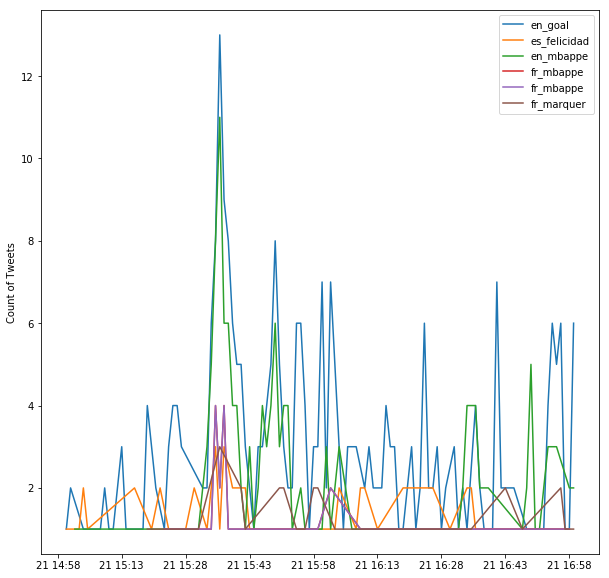

In [671]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
plots = []
for trigger in ["en_goal", "es_felicidad", "en_mbappe", "fr_mbappe", "fr_mbappe", "fr_marquer"]:
    counts, new_counts = find_counts_trigger(trigger, sws_time)

    x = list(counts.keys())
    y =  list(counts.values())

    x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0]))

    p, = plt.plot(x2,y2, label=trigger)

    plots.append(p)
plt.legend(handles = plots)
ax.xaxis_date()
plt.ylabel('Count of Tweets')
plt.show()

In [659]:
counts

{datetime.datetime(2018, 6, 21, 15, 19): 1,
 datetime.datetime(2018, 6, 21, 15, 31): 1,
 datetime.datetime(2018, 6, 21, 15, 36): 3,
 datetime.datetime(2018, 6, 21, 15, 41): 2,
 datetime.datetime(2018, 6, 21, 15, 42): 1,
 datetime.datetime(2018, 6, 21, 15, 50): 2,
 datetime.datetime(2018, 6, 21, 15, 51): 2,
 datetime.datetime(2018, 6, 21, 15, 54): 1,
 datetime.datetime(2018, 6, 21, 15, 56): 1,
 datetime.datetime(2018, 6, 21, 15, 58): 2,
 datetime.datetime(2018, 6, 21, 15, 59): 2,
 datetime.datetime(2018, 6, 21, 16, 3): 1,
 datetime.datetime(2018, 6, 21, 16, 4): 1,
 datetime.datetime(2018, 6, 21, 16, 9): 1,
 datetime.datetime(2018, 6, 21, 16, 27): 1,
 datetime.datetime(2018, 6, 21, 16, 31): 1,
 datetime.datetime(2018, 6, 21, 16, 33): 1,
 datetime.datetime(2018, 6, 21, 16, 35): 1,
 datetime.datetime(2018, 6, 21, 16, 43): 2,
 datetime.datetime(2018, 6, 21, 16, 47): 1,
 datetime.datetime(2018, 6, 21, 16, 56): 2,
 datetime.datetime(2018, 6, 21, 16, 57): 1,
 datetime.datetime(2018, 6, 21, 16,

# Examples:
<a id="example"> </a>

### Read the Tweets in Spanish and German from the TimeWindow of the match:

In [56]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 17, 15, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["es", "en", "de"]
root_dir = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

  1%|          | 73/13832 [00:00<00:19, 721.15it/s]

>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 0/23237 [00:00<?, ?it/s]

Number of Tweets Found:  13832
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


  0%|          | 91/22166 [00:00<00:24, 900.40it/s]

Number of Tweets Found:  23237
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  0%|          | 0/26190 [00:00<?, ?it/s]

Number of Tweets Found:  22166
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


 18%|█▊        | 91/505 [00:00<00:00, 908.50it/s]

Number of Tweets Found:  26190
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: de
Reading subwindow 1
Reading file => 2018-6-17_15hour.csv


  5%|▍         | 79/1701 [00:00<00:02, 787.26it/s]

Number of Tweets Found:  505
Reading subwindow 1
Reading file => 2018-6-17_16hour.csv


100%|██████████| 1701/1701 [00:01<00:00, 1073.98it/s]


Number of Tweets Found:  1701
Aggregating the Time Windows=>


In [57]:
"""  Read the event clusters """
with open("/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/GER-MEX-17_6_2018-15-de_en_es/emb_multi_de_en_es_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]

triggers = []
for event in clusters:
    triggers.append(event.split(":")[1].split("\t"))

In [58]:
#tweet_id, date, hour, minutes, text, username
from collections import Counter
import datetime as dt
counts = {}
for j in range(len(triggers)):
    for i in range(len(sws_time)):
        for term in triggers[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts:
                        counts.update({j:{}})
                    if dt_time not in counts[j]:
                        counts[j].update({dt_time:1})
                    else:
                        counts[j].update({dt_time:counts[j][dt_time]+1})


en_lozano

en_lozano

en_food

en_food

es_copa

es_copa

en_foot

en_foot

en_tell

en_tell

de_nationalhymne
de_singen
es_canción

es_canción

es_machillo

es_machillo

es_venezuela

es_venezuela

en_favorite

en_favorite

es_acabar

es_acabar

es_miedo

es_miedo

es_entrenador

es_entrenador

en_fight

en_fight

en_guy

en_guy

es_difícil

es_difícil

es_elegir

es_elegir

en_app

en_app

en_build

en_build

en_school

en_school



2018-06-17 15:35:00


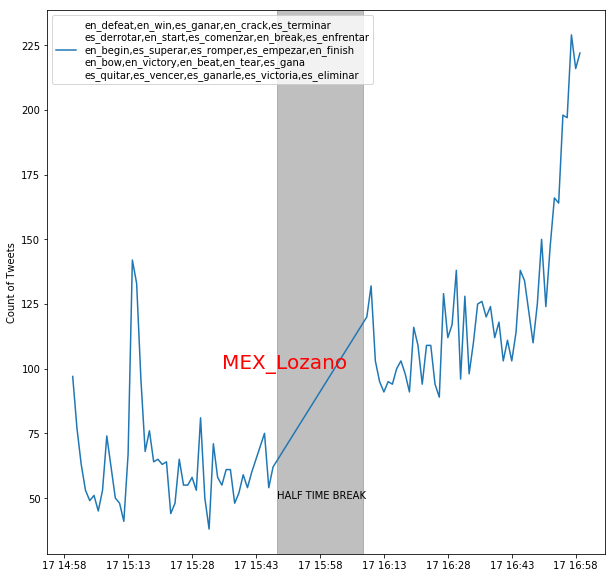

In [91]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
    
break_time_start = start + datetime.timedelta(minutes=48)
break_time_end = break_time_start + datetime.timedelta(minutes=20)
plots = []
for i in range(len(counts)):#len(counts)):
    if len(intersection(triggers[i], goal_key)) > 0: #goal_key, card_red_yellow, yellow_card_key, red_card_key
        #print(triggers[i])
        x = list(counts[i].keys())
        y =  list(counts[i].values())
        for date in goals_matches["GER-MEX-17_6_2018_15-de_es"]:
            print(date)
            plt.text(date, 100, goals_matches["GER-MEX-17_6_2018_15-de_es"][date], color="red", fontsize=20)
            plt.text(break_time_start, 50, r'HALF TIME BREAK', fontsize=10)
        x2,y2 = zip(*sorted(zip(x, y),key=lambda x: x[0]))
        x_keep = []
        y_keep = []
        for j in range(len(x2)):
            if x2[j] < break_time_start or x2[j] > break_time_end:
                x_keep.append(x2[j])
                y_keep.append(y2[j])
        p, = plt.plot(x_keep,y_keep, label=",".join(triggers[i][0:5])+"\n" +",".join(triggers[i][5:10])+"\n" +",".join(triggers[i][10:15])+"\n" +",".join(triggers[i][15:20])+"\n" +",".join(triggers[i][20:25]) )#"cluster: "+str(i))#, width=0.0001)
        plt.axvspan(break_time_start, break_time_end, color='gray', alpha=0.5)
        plots.append(p)
plt.legend(handles = plots, loc=2)
ax.xaxis_date()
plt.ylabel('Count of Tweets')
plt.show()


## Analyzing Match between Portugal and Spain: (15/06/2018 at 18:00)

In [124]:
start = datetime.datetime(2018, 6, 15, 18, 0, 0)

In [92]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 15, 18, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["en", "es", "pt"]
#root_dir = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    print("n_subwindows:",n_subwindows)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        print(sw.__str__())
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

  0%|          | 0/34593 [00:00<?, ?it/s]

>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
n_subwindows: 2
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  0%|          | 0/36927 [00:00<?, ?it/s]

Number of Tweets Found:  34593
SubWindow #41, No. of Tweets: 283612
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


  0%|          | 68/18145 [00:00<00:26, 678.16it/s]

Number of Tweets Found:  36927
SubWindow #42, No. of Tweets: 309886
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
n_subwindows: 2
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  0%|          | 85/22083 [00:00<00:26, 844.50it/s]

Number of Tweets Found:  18145
SubWindow #43, No. of Tweets: 155742
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


  2%|▏         | 80/3860 [00:00<00:04, 786.98it/s]

Number of Tweets Found:  22083
SubWindow #44, No. of Tweets: 180731
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: pt
n_subwindows: 2
Reading subwindow 1
Reading file => 2018-6-15_18hour.csv


  2%|▏         | 73/4750 [00:00<00:06, 723.90it/s]

Number of Tweets Found:  3860
SubWindow #45, No. of Tweets: 34282
Reading subwindow 1
Reading file => 2018-6-15_19hour.csv


100%|██████████| 4750/4750 [00:04<00:00, 1055.07it/s]


Number of Tweets Found:  4750
SubWindow #46, No. of Tweets: 39168
Aggregating the Time Windows=>


In [93]:
"""  Read the event clusters """
#for fname in glob.glob("/Users/meryemmhamdi/Desktop/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/POR-ESP-15_6_2018-18-en_es_pt/*"):
#    print (fname)

res_path = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/"
match = "POR-ESP-15_6_2018-18-en_es_pt/"
# MULTI 
with open(res_path + match + "emb_multi_en_es_pt_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]

triggers_multi = []
for event in clusters:
    triggers_multi.append(event.split(":")[1].split("\t"))
    
# MONO EN
with open(res_path+ match+"emb_mono_en_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]

triggers_mono_en = []
for event in clusters:
    triggers_mono_en.append(event.split(":")[1].split("\t"))
    
# MONO ES
with open(res_path+ match+"emb_mono_es_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]

triggers_mono_es = []
for event in clusters:
    triggers_mono_es.append(event.split(":")[1].split("\t"))
    
# MONO PT
with open(res_path+ match+"emb_mono_pt_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]

triggers_mono_pt = []
for event in clusters:
    triggers_mono_pt.append(event.split(":")[1].split("\t"))

In [94]:
#tweet_id, date, hour, minutes, text, username
from collections import Counter
import datetime as dt
counts_multi = {}
for j in range(len(triggers_multi)):
    for i in range(len(sws_time)):
        for term in triggers_multi[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                #print (len(sws_time[i].get_tweets_containing_segments(term)))
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    #print(tweet.text)
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts_multi:
                        counts_multi.update({j:{}})
                    if dt_time not in counts_multi[j]:
                        counts_multi[j].update({dt_time:1})
                    else:
                        counts_multi[j].update({dt_time:counts_multi[j][dt_time]+1})
                        

es_eliminar

es_eliminar

es_mediar

es_mediar

en_africans

en_africans

en_italy

en_italy

en_sad

en_sad

en_playing

en_playing

en_diego

en_diego

en_feel

en_feel

en_kill

en_kill

es_entender

es_entender

en_reach

en_reach

es_pedir

es_pedir

en_brazil

en_brazil

en_cover

en_cover

en_dream

en_dream

en_probably

en_probably

en_twitter

en_twitter

en_view

en_view

es_experiencia

es_experiencia

es_andar

es_andar

es_escuela

es_escuela

en_itv

en_itv

es_chupar

es_chupar

es_novio

es_novio

es_europa

es_europa

es_definir

es_definir



In [95]:
counts_mono_en = {}
for j in range(len(triggers_mono_en)):
    for i in range(len(sws_time)):
        for term in triggers_mono_en[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                #print (len(sws_time[i].get_tweets_containing_segments(term)))
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    #print(tweet.text)
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts_mono_en:
                        counts_mono_en.update({j:{}})
                    if dt_time not in counts_mono_en[j]:
                        counts_mono_en[j].update({dt_time:1})
                    else:
                        counts_mono_en[j].update({dt_time:counts_mono_en[j][dt_time]+1})

en_draw

en_draw

en_brazil

en_brazil

en_ball

en_ball

en_offer

en_offer

en_stay

en_stay

en_think

en_think

en_carlos

en_carlos

en_kill

en_kill

en_american

en_american

en_feel

en_feel

en_available

en_available

en_boy

en_boy



In [96]:
counts_mono_es = {}
for j in range(len(triggers_mono_es)):
    for i in range(len(sws_time)):
        for term in triggers_mono_es[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                #print (len(sws_time[i].get_tweets_containing_segments(term)))
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    #print(tweet.text)
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts_mono_es:
                        counts_mono_es.update({j:{}})
                    if dt_time not in counts_mono_es[j]:
                        counts_mono_es[j].update({dt_time:1})
                    else:
                        counts_mono_es[j].update({dt_time:counts_mono_es[j][dt_time]+1})

es_debutar

es_debutar

es_tirar

es_tirar

es_tardar

es_tardar

es_mexicano

es_mexicano

es_emocionar

es_emocionar

es_giménez

es_giménez



In [97]:
counts_mono_pt = {}
for j in range(len(triggers_mono_pt)):
    for i in range(len(sws_time)):
        for term in triggers_mono_pt[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                #print (len(sws_time[i].get_tweets_containing_segments(term)))
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    #print(tweet.text)
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts_mono_pt:
                        counts_mono_pt.update({j:{}})
                    if dt_time not in counts_mono_pt[j]:
                        counts_mono_pt[j].update({dt_time:1})
                    else:
                        counts_mono_pt[j].update({dt_time:counts_mono_pt[j][dt_time]+1})

pt_disputar

pt_disputar

pt_portugal

pt_portugal

pt_terminar

pt_terminar



2018-06-15 18:04:00
2018-06-15 18:44:00
2018-06-15 19:43:00
2018-06-15 18:24:00
2018-06-15 19:10:00
2018-06-15 19:13:00


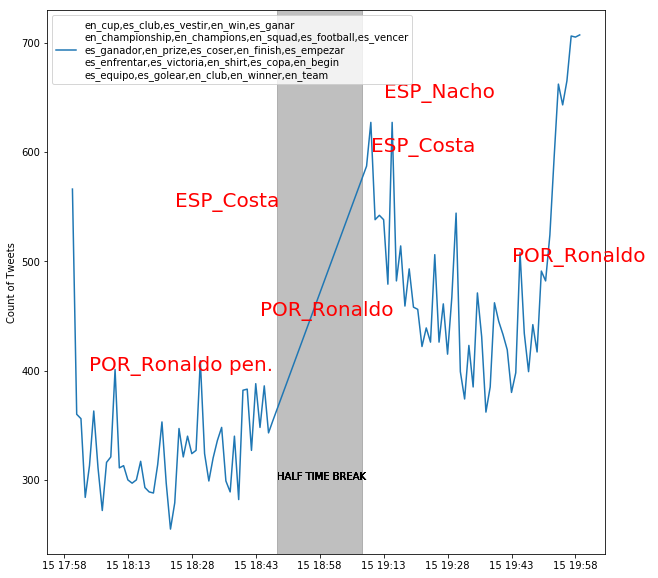

In [125]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
    
"""
for i in range(len(counts_multi)):#range(len(counts)):#len(counts)):
    if len(intersection(triggers_multi[i], goal_key)) > 0: #goal_key, card_red_yellow, yellow_card_key, red_card_key
        print(triggers_multi[i])
        x = list(counts_multi[i].keys())
        y =  list(counts_multi[i].values()) #POR-ESP-15_6_2018-18-en_es_pt
        for date in goals_matches["POR-ESP-15_6_2018_18-pt_es"]:
            plt.text(date, 1200, goals_matches["POR-ESP-15_6_2018_18-pt_es"][date])
        x2,y2 = zip(*sorted(zip(x, y),key=lambda x: x[0]))
        x_keep = []
        y_keep = []
        for j in range(len(x2)):
            if x2[j] < break_time_start or x2[j] > break_time_end:
                x_keep.append(x2[j])
                y_keep.append(y2[j])
        p, = plt.plot(x_keep,y_keep, label="cluster: "+str(i))#, width=0.0001)
        plots.append(p)
"""
plots = []
break_time_start = start + datetime.timedelta(minutes=48)
break_time_end = break_time_start + datetime.timedelta(minutes=20)
for i in range(len(counts_multi)):#len(counts)):
    if len(intersection(triggers_multi[i], goal_key)) > 0: #goal_key, card_red_yellow, yellow_card_key, red_card_key
        #print(triggers[i])
        x = list(counts_multi[i].keys())
        y =  list(counts_multi[i].values())
        ind = 0
        for date in goals_matches["POR-ESP-15_6_2018_18-pt_es"]:
            print(date)
            plt.text(date, 400+ind*50, goals_matches["POR-ESP-15_6_2018_18-pt_es"][date], color="red", fontsize=20)
            plt.text(break_time_start, 300, r'HALF TIME BREAK', fontsize=10)
            ind = ind + 1
        x2,y2 = zip(*sorted(zip(x, y),key=lambda x: x[0]))
        x_keep = []
        y_keep = []
        for j in range(len(x2)):
            if x2[j] < break_time_start or x2[j] > break_time_end:
                x_keep.append(x2[j])
                y_keep.append(y2[j])
        p, = plt.plot(x_keep,y_keep, label=",".join(triggers_multi[i][0:5])+"\n" +",".join(triggers_multi[i][5:10])+"\n" +",".join(triggers_multi[i][10:15])+"\n" +",".join(triggers_multi[i][15:20])+"\n" +",".join(triggers_multi[i][20:25]) )#"cluster: "+str(i))#, width=0.0001)
        plt.axvspan(break_time_start, break_time_end, color='gray', alpha=0.5)
        plots.append(p)

plt.legend(handles = plots)
ax.xaxis_date()
plt.ylabel('Count of Tweets')
plt.show()

## Analyzing Match between France and Australia: (16/06/2018 at 10:00)

In [117]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 16, 10, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["fr", "en"]
root_dir = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

 18%|█▊        | 97/526 [00:00<00:00, 955.33it/s]

>>>>>>>>>>>>>>> Preprocessing LANGUAGE: fr
Reading subwindow 1
Reading file => 2018-6-16_10hour.csv


  8%|▊         | 109/1335 [00:00<00:01, 1073.15it/s]

Number of Tweets Found:  526
Reading subwindow 1
Reading file => 2018-6-16_11hour.csv


  1%|          | 69/12974 [00:00<00:19, 659.93it/s]

Number of Tweets Found:  1335
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-16_10hour.csv


  0%|          | 0/19193 [00:00<?, ?it/s]

Number of Tweets Found:  12974
Reading subwindow 1
Reading file => 2018-6-16_11hour.csv


100%|██████████| 19193/19193 [00:19<00:00, 986.34it/s]


Number of Tweets Found:  19193
Aggregating the Time Windows=>


fr_soutenir

fr_soutenir

en_win

en_win

en_song

en_song

en_england

en_england

en_compete

en_compete

fr_live

fr_live

fr_boire

fr_boire

en_day

en_day

en_good

en_good

en_highlight

en_highlight

en_maybe

en_maybe

11
2018-06-16 11:13:00
2018-06-16 11:36:00
2018-06-16 11:17:00


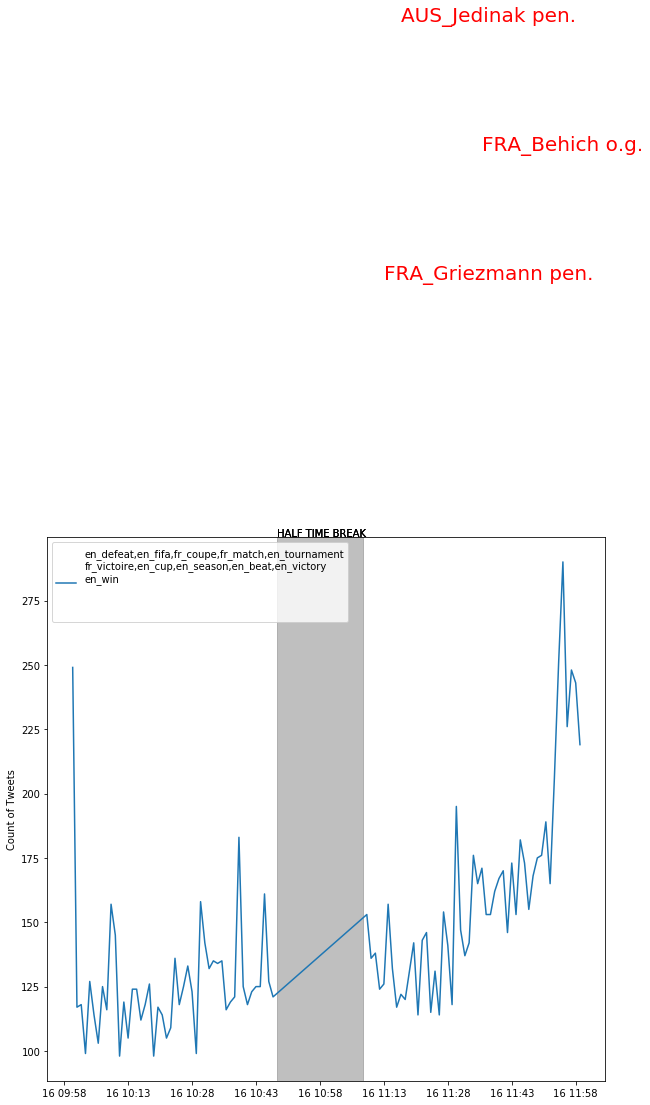

In [129]:
"""  Read the event clusters """
start = datetime.datetime(2018, 6, 16, 10, 0, 0)
with open("/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/FRA-AUS-16_6_2018-10-fr_en/emb_multi_fr_en_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]

triggers = []
for event in clusters:
    triggers.append(event.split(":")[1].split("\t"))
#tweet_id, date, hour, minutes, text, username
from collections import Counter
import datetime as dt
counts = {}
for j in range(len(triggers)):
    for i in range(len(sws_time)):
        for term in triggers[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts:
                        counts.update({j:{}})
                    if dt_time not in counts[j]:
                        counts[j].update({dt_time:1})
                    else:
                        counts[j].update({dt_time:counts[j][dt_time]+1})
                        
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
    
print(len(counts))
plots = []
break_time_start = start + datetime.timedelta(minutes=48)
break_time_end = break_time_start + datetime.timedelta(minutes=20)
for i in range(len(counts)):#len(counts)):
    if len(intersection(triggers[i], goal_key)) > 0: #goal_key, card_red_yellow, yellow_card_key, red_card_key
        #print(triggers[i])
        x = list(counts[i].keys())
        y =  list(counts[i].values())
        ind = 0
        for date in goals_matches["FRA-AUS-16_6_2018_10-fr_en"]:
            print(date)
            plt.text(date, 400+ind*50, goals_matches["FRA-AUS-16_6_2018_10-fr_en"][date], color="red", fontsize=20)
            plt.text(break_time_start, 300, r'HALF TIME BREAK', fontsize=10)
            ind = ind + 1
        x2,y2 = zip(*sorted(zip(x, y),key=lambda x: x[0]))
        x_keep = []
        y_keep = []
        for j in range(len(x2)):
            if x2[j] < break_time_start or x2[j] > break_time_end:
                x_keep.append(x2[j])
                y_keep.append(y2[j])
        p, = plt.plot(x_keep,y_keep, label=",".join(triggers[i][0:5])+"\n" +",".join(triggers[i][5:10])+"\n" +",".join(triggers[i][10:15])+"\n" +",".join(triggers[i][15:20])+"\n" +",".join(triggers[i][20:25]) )#"cluster: "+str(i))#, width=0.0001)
        plt.axvspan(break_time_start, break_time_end, color='gray', alpha=0.5)
        plots.append(p)

plt.legend(handles = plots)
ax.xaxis_date()
plt.ylabel('Count of Tweets')
plt.show()

## Analyzing Match between Brazil and Switerland: (17/06/2018 at 18:00)

In [130]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 17, 18, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["de", "fr", "it", "pt"]
root_dir = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

  4%|▍         | 102/2563 [00:00<00:02, 1017.77it/s]

>>>>>>>>>>>>>>> Preprocessing LANGUAGE: de
Reading subwindow 1
Reading file => 2018-6-17_18hour.csv


  9%|▊         | 106/1243 [00:00<00:01, 1053.65it/s]

Number of Tweets Found:  2563
Reading subwindow 1
Reading file => 2018-6-17_19hour.csv


  6%|▋         | 84/1303 [00:00<00:01, 832.76it/s]

Number of Tweets Found:  1243
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: fr
Reading subwindow 1
Reading file => 2018-6-17_18hour.csv


 11%|█         | 86/801 [00:00<00:00, 855.98it/s]

Number of Tweets Found:  1303
Reading subwindow 1
Reading file => 2018-6-17_19hour.csv


  6%|▌         | 91/1502 [00:00<00:01, 909.65it/s]

Number of Tweets Found:  801
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: it
Reading subwindow 1
Reading file => 2018-6-17_18hour.csv


 10%|█         | 82/816 [00:00<00:00, 816.81it/s]

Number of Tweets Found:  1502
Reading subwindow 1
Reading file => 2018-6-17_19hour.csv


  1%|          | 87/13245 [00:00<00:15, 868.54it/s]

Number of Tweets Found:  816
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: pt
Reading subwindow 1
Reading file => 2018-6-17_18hour.csv


  1%|          | 100/14452 [00:00<00:14, 996.26it/s]

Number of Tweets Found:  13245
Reading subwindow 1
Reading file => 2018-6-17_19hour.csv


100%|██████████| 14452/14452 [00:11<00:00, 1257.55it/s]


Number of Tweets Found:  14452
Aggregating the Time Windows=>


In [132]:
goals_matches.keys()

dict_keys(['RUS-KSA-14_6_2018_15-ru_ar', 'EGY-URU-15_6_2018_12-ar_es', 'MAR-IRN-15_6_2018_15-ar_fa', 'POR-ESP-15_6_2018_18-pt_es', 'FRA-AUS-16_6_2018_10-fr_en', 'ARG-ISL-16_6_2018_13-es_is', 'PER-DEN-16_6_2018_16-es_da', 'CRO-NGA-16_6_2018_19-hr_en', 'CRC-SRB-17_6_2018_12-es_sr', 'GER-MEX-17_6_2018_15-de_es', 'BRA-SUI-17_6_2018_18-pt_de_fr_it', 'SWE-KOR-18_6_2018_12-sv_ko', 'BEL-PAN-18_6_2018_15-fr_es', 'TUN-ENG-18_6_2018_18-ar_en', 'COL-JPN-19_6_2018_12-es_ja', 'POL-SEN-19_6_2018_15-pl_fr', 'RUS-EGY-19_6_2018_18-ru_ar', 'POR-MAR-20_6_2018_12-pt_ar', 'URU-KSA-20_6_2018_15-es_ar', 'IRN-ESP-20_6_2018_18-fa_es', 'DEN-AUS-21_6_2018_12-da_en', 'FRA-PER-21_6_2018_15-fr_es', 'ARG-CRO-21_6_2018_18-es_hr', 'BRA-CRC-22_6_2018_12-pt_es', 'NGA-ISL-22_6_2018_15-en_is', 'SRB-SUI-22_6_2018_18-sr_de_fr_it', 'BEL-TUN-23_6_2018_12-fr_ar', 'KOR-MEX-23_6_2018_15-ko_es', 'GER-SWE-23_6_2018_18-de_sv', 'ENG-PAN-24_6_2018_12-en_es', 'JPN-SEN-24_6_2018_15-ja_fr', 'POL-COL-24_6_2018_18-pl_es', 'URU-RUS-25_6_201

en_loss
en_defeat
en_playing
en_win
en_play
en_won
en_victory
fr_victoire

en_loss
en_defeat
en_playing
en_win
en_play
en_won
en_victory
fr_victoire

en_rica
en_brazilian
en_costa
en_mexico
en_spanish
en_mexican
en_peru
en_panama

en_rica
en_brazilian
en_costa
en_mexico
en_spanish
en_mexican
en_peru
en_panama

de_hummels

de_hummels

en_stay
en_bring
en_leave
en_wrong
en_left
en_provide
en_remain
en_right
en_return
en_deliver
en_offer

en_stay
en_bring
en_leave
en_wrong
en_left
en_provide
en_remain
en_right
en_return
en_deliver
en_offer

en_major
en_entertaining
en_impressed
en_disappointing
en_stunning
en_surprised
en_proud
en_tell
en_welcome
en_sorry
en_remind
en_thank
en_key
en_forget
en_disappointed
en_appreciate
en_ask
en_glad
en_shocking
en_know
en_understand
en_exciting
en_main
en_remember
en_explain
en_underestimate
en_regret
en_important
en_sad
en_happy
en_excited
en_interesting
en_congratulations
en_congratulation

en_major
en_entertaining
en_impressed
en_disappointing
en_stu

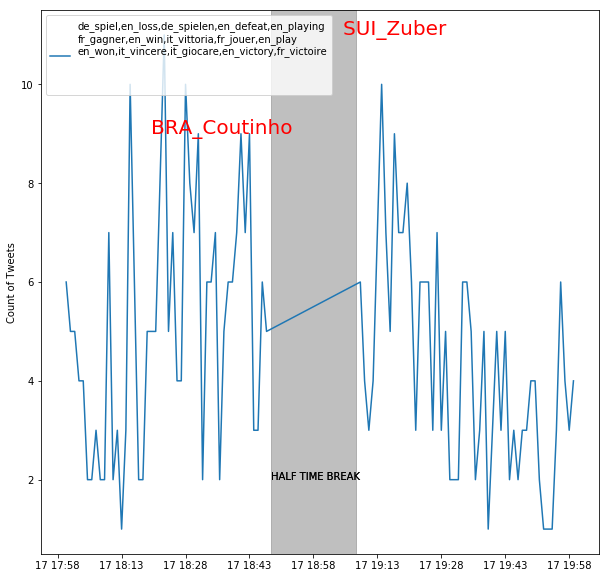

In [140]:
"""  Read the event clusters """
#with open("/Users/meryemmhamdi/Documents/Results/EvDet/world_cup_18/multi_de_fr_it_pt/emb_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
with open("/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/BRA-SUI-17_6_2018-18-de_en_fr_pt_it/emb_multi_de_en_fr_pt_it_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]
    
triggers = []
for event in clusters:
    triggers.append(event.split(":")[1].split("\t"))
#tweet_id, date, hour, minutes, text, username
from collections import Counter
import datetime as dt
counts = {}
for j in range(len(triggers)):
    for i in range(len(sws_time)):
        for term in triggers[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts:
                        counts.update({j:{}})
                    if dt_time not in counts[j]:
                        counts[j].update({dt_time:1})
                    else:
                        counts[j].update({dt_time:counts[j][dt_time]+1})
                        
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
    
plots = []
break_time_start = start + datetime.timedelta(minutes=48)
break_time_end = break_time_start + datetime.timedelta(minutes=20)
for i in range(len(counts)):#len(counts)):
    if len(intersection(triggers[i], goal_key)) > 0: #goal_key, card_red_yellow, yellow_card_key, red_card_key
        #print(triggers[i])
        x = list(counts[i].keys())
        y =  list(counts[i].values())
        ind = 0
        for date in goals_matches["BRA-SUI-17_6_2018_18-pt_de_fr_it"]:
            print(date)
            plt.text(date, 9+ind*2, goals_matches["BRA-SUI-17_6_2018_18-pt_de_fr_it"][date], color="red", fontsize=20)
            plt.text(break_time_start, 2, r'HALF TIME BREAK', fontsize=10)
            ind = ind + 1
        x2,y2 = zip(*sorted(zip(x, y),key=lambda x: x[0]))
        x_keep = []
        y_keep = []
        for j in range(len(x2)):
            if x2[j] < break_time_start or x2[j] > break_time_end:
                x_keep.append(x2[j])
                y_keep.append(y2[j])
        p, = plt.plot(x_keep,y_keep, label=",".join(triggers[i][0:5])+"\n" +",".join(triggers[i][5:10])+"\n" +",".join(triggers[i][10:15])+"\n" +",".join(triggers[i][15:20])+"\n" +",".join(triggers[i][20:25]) )#"cluster: "+str(i))#, width=0.0001)
        plt.axvspan(break_time_start, break_time_end, color='gray', alpha=0.5)
        plots.append(p)

plt.legend(handles = plots, loc=2)
ax.xaxis_date()
plt.ylabel('Count of Tweets')
plt.show()


## Analyzing Match between Belgium and Panama: (18/06/2018 at 15:00)

In [141]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 18, 15, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["en", "fr", "es"]
root_dir = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

  0%|          | 0/25004 [00:00<?, ?it/s]

>>>>>>>>>>>>>>> Preprocessing LANGUAGE: en
Reading subwindow 1
Reading file => 2018-6-18_15hour.csv


  0%|          | 0/22455 [00:00<?, ?it/s]

Number of Tweets Found:  25004
Reading subwindow 1
Reading file => 2018-6-18_16hour.csv


 23%|██▎       | 94/405 [00:00<00:00, 931.07it/s]

Number of Tweets Found:  22455
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: fr
Reading subwindow 1
Reading file => 2018-6-18_15hour.csv


 17%|█▋        | 95/545 [00:00<00:00, 941.07it/s]

Number of Tweets Found:  405
Reading subwindow 1
Reading file => 2018-6-18_16hour.csv


  1%|          | 90/10598 [00:00<00:11, 899.63it/s]

Number of Tweets Found:  545
>>>>>>>>>>>>>>> Preprocessing LANGUAGE: es
Reading subwindow 1
Reading file => 2018-6-18_15hour.csv


  1%|          | 84/12501 [00:00<00:14, 837.40it/s]

Number of Tweets Found:  10598
Reading subwindow 1
Reading file => 2018-6-18_16hour.csv


100%|██████████| 12501/12501 [00:12<00:00, 1013.65it/s]


Number of Tweets Found:  12501
Aggregating the Time Windows=>


en_cup

en_cup

en_japan

en_japan

es_portero

es_portero

en_break

en_break

es_preparar

es_preparar

en_correct

en_correct

en_compete

en_compete

es_confirmar

es_confirmar

en_tea

en_tea

es_pasar

es_pasar

fr_hymne
es_llorar

es_llorar

en_brilliant

en_brilliant

en_predict

en_predict

es_méxico

es_méxico

en_think

en_think

en_cheer

en_cheer

en_stupid

en_stupid

en_choose

en_choose

en_tackle

en_tackle

en_maybe

en_maybe

en_high

en_high

es_hombre

es_hombre

en_party

en_party

2018-06-18 16:02:00
2018-06-18 16:24:00
2018-06-18 16:30:00


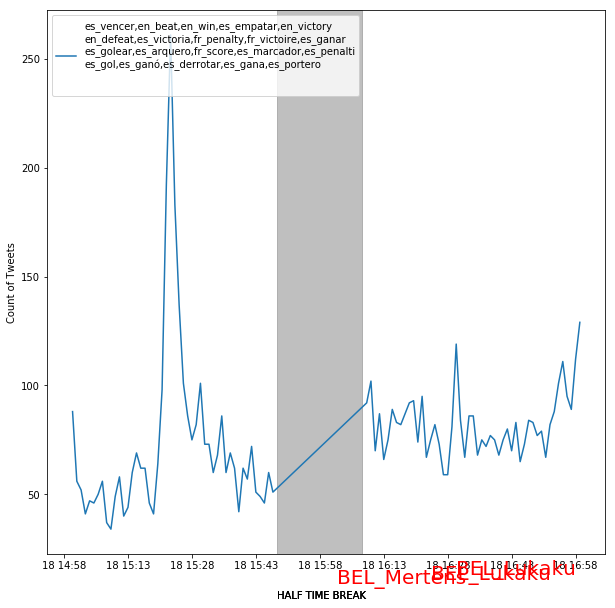

In [145]:
start = datetime.datetime(2018, 6, 18, 15, 0, 0)
"""  Read the event clusters """
path = "/Users/meryemmhamdi/Documents/Rig4/meryemRig4/home/meryem/meryem/Results/EvDet/world_cup_18/"
match = "BEL-PAN-18_6_2018-15-fr_en_es/"
with open(path + match + "emb_multi_fr_en_es_mono-trigger_3-neigh_10-min-cluster-seg.txt") as file:
    clusters = file.readlines()[5:]

triggers = []
for event in clusters:
    triggers.append(event.split(":")[1].split("\t"))
#tweet_id, date, hour, minutes, text, username
from collections import Counter
import datetime as dt
counts = {}
for j in range(len(triggers)):
    for i in range(len(sws_time)):
        for term in triggers[j]:
            if sws_time[i].get_tweets_containing_segments(term) is not None:
                for tweet in sws_time[i].get_tweets_containing_segments(term):
                    date_time = tweet.date+ "_"+ tweet.hour+ ":"+ tweet.minutes  
                    year = int(tweet.date.split("-")[0])
                    month = int(tweet.date.split("-")[1])
                    day = int(tweet.date.split("-")[2])
                    hour = int(tweet.hour)
                    minutes = int(tweet.minutes)
                    dt_time = dt.datetime(year, month, day, hour, minutes, 0)
                    if j not in counts:
                        counts.update({j:{}})
                    if dt_time not in counts[j]:
                        counts[j].update({dt_time:1})
                    else:
                        counts[j].update({dt_time:counts[j][dt_time]+1})

new_counts = {}
for i in range(len(counts)):
    max_value, max_index = np.max(list(counts[i].values())), np.argmax(list(counts[i].values()))
    min_value = np.min(list(counts[i].values()))
    new_counts.update({i:{}})
    for j in range(len(list(counts[i].values()))):
        key = list(counts[i].keys())[j]
        if j == max_index:
            new_counts[i].update({key:max_value})
        else:
            new_counts[i].update({key:min_value})
            
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
plots = []

break_time_start = start + datetime.timedelta(minutes=48)
break_time_end = break_time_start + datetime.timedelta(minutes=20)
for i in range(len(counts)):#len(counts)):
    if len(intersection(triggers[i], goal_key)) > 0: #goal_key, card_red_yellow, yellow_card_key, red_card_key
        #print(triggers[i])
        x = list(counts[i].keys())
        y =  list(counts[i].values())
        ind = 0
        for date in goals_matches["BEL-PAN-18_6_2018_15-fr_es"]:
            print(date)
            plt.text(date, 9+ind*2, goals_matches["BEL-PAN-18_6_2018_15-fr_es"][date], color="red", fontsize=20)
            plt.text(break_time_start, 2, r'HALF TIME BREAK', fontsize=10)
            ind = ind + 1
        x2,y2 = zip(*sorted(zip(x, y),key=lambda x: x[0]))
        x_keep = []
        y_keep = []
        for j in range(len(x2)):
            if x2[j] < break_time_start or x2[j] > break_time_end:
                x_keep.append(x2[j])
                y_keep.append(y2[j])
        p, = plt.plot(x_keep,y_keep, label=",".join(triggers[i][0:5])+"\n" +",".join(triggers[i][5:10])+"\n" +",".join(triggers[i][10:15])+"\n" +",".join(triggers[i][15:20])+"\n" +",".join(triggers[i][20:]) )#"cluster: "+str(i))#, width=0.0001)
        plt.axvspan(break_time_start, break_time_end, color='gray', alpha=0.5)
        plots.append(p)

plt.legend(handles = plots, loc=2)
ax.xaxis_date()
plt.ylabel('Count of Tweets')
plt.show()

In [397]:
count_events_1_std

{datetime.datetime(2018, 6, 18, 15, 0),
 datetime.datetime(2018, 6, 18, 15, 2),
 datetime.datetime(2018, 6, 18, 15, 5),
 datetime.datetime(2018, 6, 18, 15, 6),
 datetime.datetime(2018, 6, 18, 15, 16),
 datetime.datetime(2018, 6, 18, 15, 17),
 datetime.datetime(2018, 6, 18, 15, 18),
 datetime.datetime(2018, 6, 18, 15, 20),
 datetime.datetime(2018, 6, 18, 15, 21),
 datetime.datetime(2018, 6, 18, 15, 22),
 datetime.datetime(2018, 6, 18, 15, 23),
 datetime.datetime(2018, 6, 18, 15, 24),
 datetime.datetime(2018, 6, 18, 15, 25),
 datetime.datetime(2018, 6, 18, 15, 26),
 datetime.datetime(2018, 6, 18, 15, 28),
 datetime.datetime(2018, 6, 18, 15, 29),
 datetime.datetime(2018, 6, 18, 15, 30),
 datetime.datetime(2018, 6, 18, 15, 32),
 datetime.datetime(2018, 6, 18, 15, 33),
 datetime.datetime(2018, 6, 18, 15, 34),
 datetime.datetime(2018, 6, 18, 15, 35),
 datetime.datetime(2018, 6, 18, 15, 38),
 datetime.datetime(2018, 6, 18, 15, 41),
 datetime.datetime(2018, 6, 18, 15, 43),
 datetime.datetime(2

In [398]:
count_events_2_std

{datetime.datetime(2018, 6, 18, 15, 0),
 datetime.datetime(2018, 6, 18, 15, 2),
 datetime.datetime(2018, 6, 18, 15, 6),
 datetime.datetime(2018, 6, 18, 15, 16),
 datetime.datetime(2018, 6, 18, 15, 21),
 datetime.datetime(2018, 6, 18, 15, 22),
 datetime.datetime(2018, 6, 18, 15, 23),
 datetime.datetime(2018, 6, 18, 15, 24),
 datetime.datetime(2018, 6, 18, 15, 25),
 datetime.datetime(2018, 6, 18, 15, 26),
 datetime.datetime(2018, 6, 18, 15, 30),
 datetime.datetime(2018, 6, 18, 15, 34),
 datetime.datetime(2018, 6, 18, 15, 38),
 datetime.datetime(2018, 6, 18, 15, 45),
 datetime.datetime(2018, 6, 18, 16, 11),
 datetime.datetime(2018, 6, 18, 16, 17),
 datetime.datetime(2018, 6, 18, 16, 20),
 datetime.datetime(2018, 6, 18, 16, 24),
 datetime.datetime(2018, 6, 18, 16, 30),
 datetime.datetime(2018, 6, 18, 16, 54),
 datetime.datetime(2018, 6, 18, 16, 55),
 datetime.datetime(2018, 6, 18, 16, 56),
 datetime.datetime(2018, 6, 18, 16, 57),
 datetime.datetime(2018, 6, 18, 16, 58),
 datetime.datetime(

In [399]:
count_events_3_std

{datetime.datetime(2018, 6, 18, 15, 21),
 datetime.datetime(2018, 6, 18, 15, 22),
 datetime.datetime(2018, 6, 18, 15, 23),
 datetime.datetime(2018, 6, 18, 15, 24),
 datetime.datetime(2018, 6, 18, 15, 45),
 datetime.datetime(2018, 6, 18, 16, 57),
 datetime.datetime(2018, 6, 18, 16, 58),
 datetime.datetime(2018, 6, 18, 16, 59)}

In [384]:
i = 1
x = list(counts[i].keys()) 
y = list(counts[i].values())
x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0]))

[-0.5        -0.49166667 -0.48333333 -0.475      -0.46666667 -0.45833333
 -0.45       -0.44166667 -0.43333333 -0.425      -0.41666667 -0.40833333
 -0.4        -0.39166667 -0.38333333 -0.375      -0.36666667 -0.35833333
 -0.35       -0.34166667 -0.33333333 -0.325      -0.31666667 -0.30833333
 -0.3        -0.29166667 -0.28333333 -0.275      -0.26666667 -0.25833333
 -0.25       -0.24166667 -0.23333333 -0.225      -0.21666667 -0.20833333
 -0.2        -0.19166667 -0.18333333 -0.175      -0.16666667 -0.15833333
 -0.15       -0.14166667 -0.13333333 -0.125      -0.11666667 -0.10833333
 -0.1        -0.09166667 -0.08333333 -0.075      -0.06666667 -0.05833333
 -0.05       -0.04166667 -0.03333333 -0.025      -0.01666667 -0.00833333
  0.          0.00833333  0.01666667  0.025       0.03333333  0.04166667
  0.05        0.05833333  0.06666667  0.075       0.08333333  0.09166667
  0.1         0.10833333  0.11666667  0.125       0.13333333  0.14166667
  0.15        0.15833333  0.16666667  0.175       0

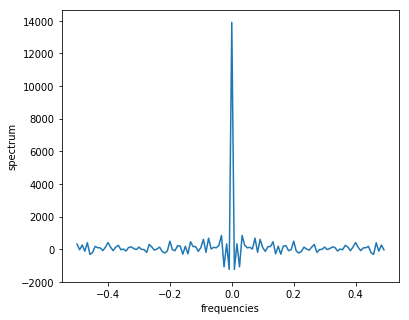

In [385]:
#Program for Fourier Transformation
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
spectrum = fft.fft(y2)
timestep = 1 # assume samples at regular intervals
freq = fft.fftfreq(len(spectrum),d=timestep)
freq=fft.fftshift(freq)
spectrum = fft.fftshift(spectrum)
plt.figure(0,figsize=(5.0*1.21,5.0))
plt.plot(freq,spectrum)
print (freq)
plt.xlabel("frequencies")
plt.ylabel("spectrum")
plt.savefig("/tmp/figure.png")

In [366]:
a = [1,2]

if any([5,2]) in a:
    print("yes")

yes


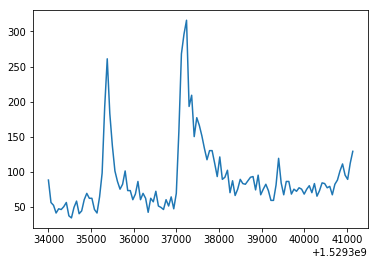

In [283]:
from scipy.interpolate import spline, interp1d
import pandas as pd
"""
mean_y = np.mean(list(counts[2].values()))
kept_j = []
y = []
for j in range(0,len(list(counts[2].values()))):
    if list(counts[2].values())[j] >= mean_y:
        kept_j.append(j)
        y.append(list(counts[i].values())[j])
x = [list(counts[2].keys())[j] for j in range(0, len(list(counts[i].keys()))) if j in kept_j]
"""
x = list(counts[2].keys()) 
y = list(counts[2].values())
x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0]))

start = pd.Timestamp(str(x2[0].year)+"-"+str(x2[0].month)+"-"+str(x2[0].day))
end = pd.Timestamp(str(x2[-1].year)+"-"+str(x2[-1].month)+"-"+str(x2[-1].day))
t = np.linspace(start.value, end.value, len(y2))
xnew = pd.to_datetime(t)

import datetime, numpy as np
import calendar

def toTimestamp(d):
      return calendar.timegm(d.timetuple())

arr1 = np.array([toTimestamp(date) for date in x2]) 
t = np.linspace(min(arr1), max(arr1), len(y2))

#result = np.interp(arr1,y2)
#print (result)
#power_smooth = interp1d(arr1,y2)
power_smooth = spline(arr1,y2,t)

#print(power_smooth(np.array(arr1)))
plt.plot(t,power_smooth)
plt.show()

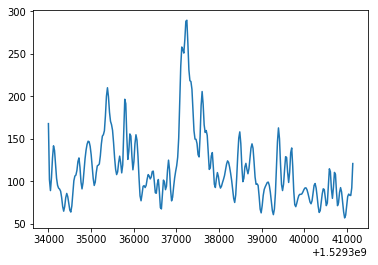

In [260]:
T = np.array([toTimestamp(date) for date in x2]) 
xnew = np.linspace(min(T),max(T),300) #300 represents number of points to make between T.min and T.max

power_smooth = spline(T,y2,xnew)

plt.plot(xnew,power_smooth)
plt.show()

TypeError: index type not supported

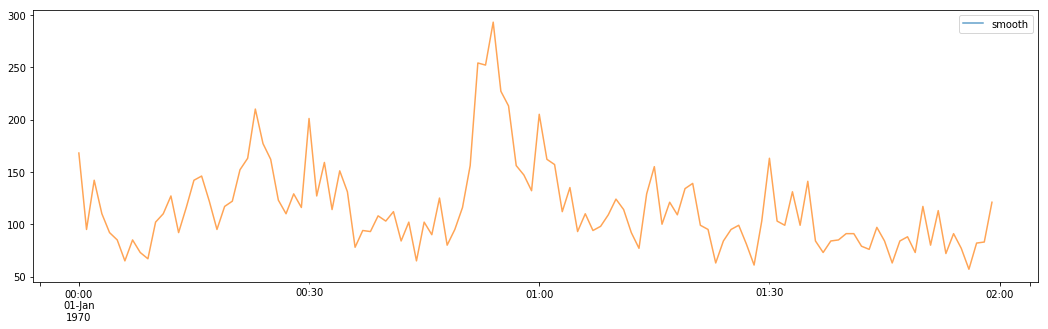

In [221]:
from scipy.interpolate import spline
import pandas as pd

x = list(counts[1].keys())
y =  list(counts[1].values())
x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0]))
T = x2
y = y2
index_minute = pd.date_range(x2[0], x2[-1], freq='1T')
df = pd.DataFrame()
df["value"] = y2
df_smooth = df.reindex(index=index_minute).interpolate('cubic')
df_smooth = df_smooth.rename(columns={'value':'smooth'})

fig, axs = plt.subplots(1,1, figsize=(18,5))
df_smooth.plot(ax=axs, alpha=0.7)

df.plot(ax=axs, alpha=0.7)
fig.show()



#xnew = np.linspace(min(T),max(T),300) 

#power_smooth = spline(T,y,xnew)

#plt.plot(xnew,power_smooth)
#plt.show()

## Analyzing Match between England and Panama: (24/06/2018 at 12:00)

In [ ]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 24, 12, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["en", "es"]
root_dir = "/Users/meryemmhamdi/Documents/meryemRig1/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

## Analyzing Match between Australia and Peru: (26/06/2018 at 14:00)

In [ ]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 26, 14, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["en", "es"]
root_dir = "/Users/meryemmhamdi/Documents/meryemRig1/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

## Analyzing Match between Nigeria and Argentina: (26/06/2018 at 18:00)

In [ ]:
from BurstySegmentExtraction.detect_bursty_segments import *
#from PreprocessingModule.prepare_csv_data import *
#from PreprocessingModule.preprocess_sp_tweets import *
from EventSegmentClustering.cluster_events import *
import datetime
import itertools

def union(*dicts):
    return dict(itertools.chain.from_iterable(dct.items() for dct in dicts))

start = datetime.datetime(2018, 6, 26, 18, 0, 0)
time_window_size = 2
sub_window_size = 1  # 1 hour
start_time = start  # to be changed to evaluate over another time window
n_time_windows = 1 #
    
bs = BurstySegmentation()
ed = EventDetector()
lang_set = ["en", "es", "fr"]
root_dir = "/Users/meryemmhamdi/Documents/meryemRig1/home/meryem/meryem/Datasets/EvDet/world_cup_18/csv_files/"
sws = []
for lang in lang_set:
    print(">>>>>>>>>>>>>>> Preprocessing LANGUAGE:", lang)
    cleaned_tweet_dir = root_dir + "cleaned_tweets/" +lang + "/"
    sub_windows_dir = cleaned_tweet_dir + "sub-windows/"
    
    # Initialize the TimeWindow
    subwindows = []
    segments_subs = []
    n_subwindows = int(time_window_size/sub_window_size)
    for sub_window_no in range(n_subwindows):
        sw = bs.read_subwindow(sub_windows_dir, start_time, sub_window_size, lang)
        start_time += datetime.timedelta(hours=sub_window_size)
        subwindows.append(sw)
        segments_subs.append(sw.get_segments())

    tw = TimeWindow(subwindows)
    
    sws.append(segments_subs)
    start_time = start

print("Aggregating the Time Windows=>")
sws_langs = map(list, zip(*sws))
sws_time = []

for sws_lang in sws_langs:
    multi_lang_segment = union(*sws_lang)
    sws_time.append(SubWindow(multi_lang_segment))

/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


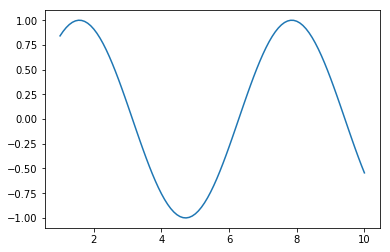

In [42]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

f,a = plt.subplots()
x = np.linspace(1,10,100)
y = np.sin(x)
a.plot(x,y)
pos = []
def onclick(event):
    pos.append([event.xdata,event.ydata])
f.canvas.mpl_connect('button_press_event', onclick)
f.show()

<IPython.core.display.Javascript object>


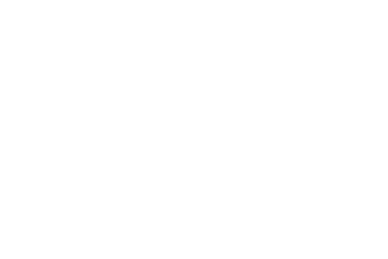

<IPython.core.display.Javascript object>


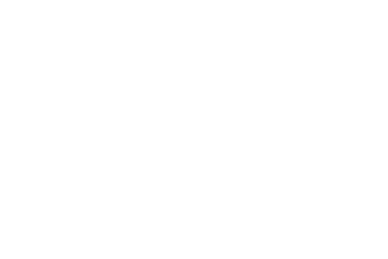

In [43]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

## Recall/Precision Tradeoff:

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-168-39e933216c7e>", line 4, in <module>
    plt.plot(precisions, recalls,'r',linewidth=1.0)
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py", line 3261, in plot
    ret = ax.plot(*args, **kwargs)
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py", line 1717, in inner
    return func(ax, *args, **kwargs)
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 1372, in plot
    for line in self._get_lines(*args, **kwargs):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 404, in _grab_next_args
    for seg in self._plot_args(this, kwargs):
  File "/Users/meryemmhamdi/anaconda3/lib/python3.6

ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

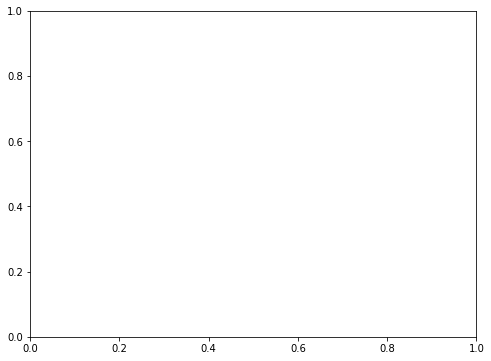

In [168]:
plt.figure(figsize=[8,6])
precisions = [58.66,25,50.5,50.64,33.33,56.35,50,50,66,67,100,50,52.87]
recalls = [66.49,25,80.88,82.33,33.33,78.39,33.34,50,22.22,69.05,27.5,88.32]
plt.plot(precisions, recalls,'r',linewidth=1.0)
plt.xlabel('Precision',fontsize=16)
plt.ylabel('Recall',fontsize=16)
plt.title('Precision-Recall Tradeoff',fontsize=16)